In [1]:
import tensorflow as tf
from helpers import *
from convnet_experiment import *

In [2]:
%matplotlib inline

In [137]:
cd kaggle-dsb/

/Users/omakhlouf/Desktop/Data Science Bowl/kaggle-dsb


In [3]:
DATA_DIR = 'netdata'
train = np.load(os.path.join(DATA_DIR, 'standardized_train.npy'))
train_labels = np.load(os.path.join(DATA_DIR, 'labels_train.npy'))
test = np.load(os.path.join(DATA_DIR, 'standardized_test.npy'))
test_labels = np.load(os.path.join(DATA_DIR, 'labels_test.npy'))

In [127]:
labels = np.concatenate((train_labels, test_labels))
labels.shape

(1000,)

In [135]:
np.sum(labels > 80)

631

In [8]:
xv, yv = batch(test, test_labels)

In [14]:
xv.shape

(28800, 32, 32, 9)

In [6]:
test.shape

(3, 200, 2, 8, 32, 32)

In [155]:
np.sum(labels<42.69)

100

In [171]:
[np.percentile(labels, 10*i) for i in range(1,10)]

[42.690000000000005,
 54.0,
 69.799999999999997,
 85.900000000000006,
 109.0,
 131.0,
 155.63,
 177.25999999999999,
 208.78999999999999]

In [4]:
def make_class_label(y):
    ''' Return an encoded version of y in one of 10 percentile classes '''
    y = np.array(y).astype(int)
    encodings = np.zeros((y.shape[0], 2))
    for i in range(y.shape[0]):
        if y[i] < 100.:
            encodings[i, 0] = 1.
        else:
            encodings[i, 1] = 1.

    return encodings

In [16]:
enc = make_class_label(labels)

## Evaluate the UNDER-110 Model

In [304]:
RUN_NAME = 'CRPS-MODEL-3.0'
DATA_DIR = 'netdata'
ITERS = 100000
START_ITER = 0
MODEL_LOAD_PATH = None
PIC_WIDTH = 32
### Architectural Hyperparameters
DEPTH_1 = 20         # The output depth of the first convolutional layer
DEPTH_2 = 40         # The output depth of the second convolutional layer
DEPTH_3 = 80         # The output depth of the second convolutional layer
DEPTH_4 = 150        # The output depth of the second convolutional layer
DEPTH_5 = 150        # The output depth of the second convolutional layer
DEPTH_6 = 150        # The output depth of the second convolutional layer
NUM_HIDDEN = 400     # Number of hidden units in the hidden layer
NUM_OUTPUTS = 600    # Number of output classes in the softmax layer
KERNEL_X = 3         # The width of the convolution kernel (using same for 1st and 2nd layers)
KERNEL_Y = 3         # The height of the convolution kernel (using same for 1st and 2nd layers)
mu = 0.0001
LEARNING_RATE = 1e-4
REGULARIZE_BIAS = False
NUM_INPUTS = 3       # Number of input channels
NUM_REPS = 64
TRAIN_LABEL_NOISE_STD = 2.
TRAIN_LABEL_SMOOTHING_STD = 0.
DATA_AUGMENTATION = True
ENLARGED = False
SHIFT = False
DIASTOLE = False
UNDER = False
DATA_MEDIAN_FILTER = False
WEIGHTS_PATH = None
##################################################################################################
NUM_INPUTS = 9       # Number of input channels
NUM_REPS = 144
TRAIN_LABEL_NOISE_STD = 1.
TRAIN_LABEL_SMOOTHING_STD = 2.
DATA_AUGMENTATION = True
RUN_NAME = 'UNDER2-110'
UNDER = True
LEARNING_RATE = 1e-3

In [306]:
graph = tf.Graph()
with graph.as_default():
    ####################################### INPUT/OUTPUT PLACEHOLDERS ##############################################
    x = tf.placeholder(tf.float32, shape=[None, PIC_WIDTH, PIC_WIDTH, NUM_INPUTS]) #Placeholder for the input images
    y_ = tf.placeholder(tf.float32, shape=[None, NUM_OUTPUTS]) #Placeholder for the label cdfs

    ####################################### FIRST CONVOLUTIONAL LAYER ##############################################
    # The weight tensor has dimensions [kernel_size_x, kernel_size_y, num_input_channels, num_output_channels]
    W_conv1 = weight_variable([KERNEL_X, KERNEL_Y, NUM_INPUTS, DEPTH_1])
    b_conv1 = bias_variable([DEPTH_1])
    #Take the input image, reshape it to a 4D tensor with dimensions: [_, image_width, image_height, num_channels]
    #x_image = tf.reshape(x, [-1,32,32,3])
    # Convolve with kernel -> add bias -> apply ReLU -> max pool 
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    ####################################### SECOND CONVOLUTIONAL LAYER ##############################################
    W_conv2 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_1, DEPTH_2])
    b_conv2 = bias_variable([DEPTH_2])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    ####################################### THIRD CONVOLUTIONAL LAYER ##############################################
    W_conv3 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_2, DEPTH_3])
    b_conv3 = bias_variable([DEPTH_3])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)

    ####################################### FOURTH CONVOLUTIONAL LAYER ##############################################
    #W_conv4 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_3, DEPTH_4])
    W_conv4 = weight_variable([2, 2, DEPTH_3, DEPTH_4]) #Modified this to support 5x5
    b_conv4 = bias_variable([DEPTH_4])

    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
    # ####################################### FIFTH CONVOLUTIONAL LAYER ##############################################
    #This layer uses a 1x1 convolution
    W_conv5 = weight_variable([1, 1, DEPTH_4, DEPTH_5])
    b_conv5 = bias_variable([DEPTH_5])

    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = tf.nn.avg_pool(h_conv5,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_pool5_flat = tf.reshape(h_pool5, [-1, DEPTH_6])

    ############################################### DROPOUT ##########################################################
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_pool5_flat, keep_prob)

    ############################################# SOFTMAX OUTPUT LAYER ###############################################
    W_fc2 = weight_variable([DEPTH_5, NUM_OUTPUTS])
    b_fc2 = bias_variable([NUM_OUTPUTS])

    y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

    #Cumulative sum
    y = cumsum(y_conv)
    ##################################### SETTING UP THE OPTIMISATION PROBLEM #####################################
    crps = tf.reduce_mean(tf.reduce_mean(tf.square(y - y_), 1)) #y_ here should be the label cdfs
    ### Could add learning rate decay here - 1e-4 is the current learning rate
    loss = crps + mu*(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)
                    + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                    + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_fc2))
    if REGULARIZE_BIAS:
        loss += mu*(tf.nn.l2_loss(b_conv1) + tf.nn.l2_loss(b_conv2)
                + tf.nn.l2_loss(b_conv3) + tf.nn.l2_loss(b_conv4)
                + tf.nn.l2_loss(b_conv5) + tf.nn.l2_loss(b_fc2))

    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    mean_y = tf.reduce_mean(tf.reshape(y,(-1, NUM_REPS, NUM_OUTPUTS)), 1)
    mean_crps = tf.reduce_mean(tf.reduce_mean(tf.square(mean_y - y_), 1))

    mean_crps_summ = tf.scalar_summary("mean crps", mean_crps)
    crps_summ = tf.scalar_summary("crps", crps)


In [307]:
MODEL_LOAD_PATH = 'UNDER2-110/model-37000'
under_cdfs = []

In [310]:
#Do this 50 at a time -> 0:50, 50:100, 100:150, 150:200
X, y = batch(test[:,100:200], [])
under_cdfs = list(under_cdfs)
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    under_cdfs.extend(mean_y.eval(feed_dict={x:X, keep_prob: 1}))

under_cdfs = np.array(under_cdfs)
under_cdfs.shape

(200, 600)

### Smooth the CDFs

In [311]:
width = 20
h = np.ones(width)/float(width)
smooth_under_cdfs = np.zeros_like(under_cdfs)
for i in range(under_cdfs.shape[0]):
    smoos = np.convolve(h,under_cdfs[i])
    smoos = smoos[width/2:-(width/2 - 1)]
    smoos[-(width/2):] = 1.
    smooth_under_cdfs[i,:] = smoos
under_110_errs = np.mean(np.square(smooth_under_cdfs[:] - make_cdf(test_labels[:])), 1)

In [312]:
under_110_errs.mean()

0.067574985609096541

In [329]:
mask = (test_labels < 100)#*(test_labels > 80)
under_110_errs[mask].mean()#, over_80_errs[mask].mean()

0.012421334803685674

In [330]:
best_errs[mask].mean() - under_110_errs[mask].mean()

0.0016563054325861061

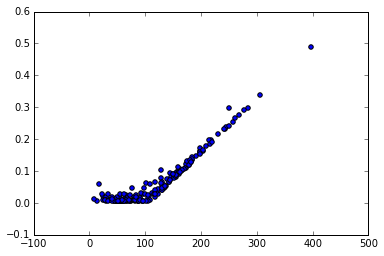

In [323]:
plt.scatter(test_labels, under_110_errs)
#plt.scatter(test_labels, over_80_errs, c='r')

In [433]:
pests = np.argmax(best_cdfs > 0.5, axis=1)
pests.shape

(200,)

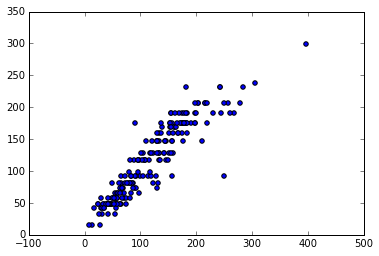

In [434]:
plt.scatter(test_labels, pests)

## Evaluate the OVER-80 Model

In [4]:
RUN_NAME = 'CRPS-MODEL-3.0'
DATA_DIR = 'netdata'
ITERS = 100000
START_ITER = 0
MODEL_LOAD_PATH = None
PIC_WIDTH = 32
### Architectural Hyperparameters
DEPTH_1 = 20         # The output depth of the first convolutional layer
DEPTH_2 = 40         # The output depth of the second convolutional layer
DEPTH_3 = 80         # The output depth of the second convolutional layer
DEPTH_4 = 150        # The output depth of the second convolutional layer
DEPTH_5 = 150        # The output depth of the second convolutional layer
DEPTH_6 = 150        # The output depth of the second convolutional layer
NUM_HIDDEN = 400     # Number of hidden units in the hidden layer
NUM_OUTPUTS = 600    # Number of output classes in the softmax layer
KERNEL_X = 3         # The width of the convolution kernel (using same for 1st and 2nd layers)
KERNEL_Y = 3         # The height of the convolution kernel (using same for 1st and 2nd layers)
mu = 0.0001
LEARNING_RATE = 1e-4

REGULARIZE_BIAS = False


NUM_INPUTS = 3       # Number of input channels
NUM_REPS = 64
MBSIZE = 100

TRAIN_LABEL_NOISE_STD = 2.
TRAIN_LABEL_SMOOTHING_STD = 0.
DATA_AUGMENTATION = False

DATA_MEDIAN_FILTER = False
DATA_UNIT_VAR = False
VAL_PER = 1000
DROPOUT = 0.5
ALSO_MIN_RMSE = False
TEMP_DIR_PATH = '.'
TRAIN_ALL = False
FILTER_BY_LABEL = False

############################
NUM_INPUTS = 9       # Number of input channels
NUM_REPS = 144
TRAIN_LABEL_NOISE_STD = 1.
TRAIN_LABEL_SMOOTHING_STD = 2.
DATA_AUGMENTATION = True
RUN_NAME = 'OVER-80'
FILTER_BY_LABEL = True
LEARNING_RATE = 1e-3
MBSIZE = 2000
VAL_PER = 200

In [5]:
graph = tf.Graph()
with graph.as_default():
    ####################################### INPUT/OUTPUT PLACEHOLDERS ##############################################
    x = tf.placeholder(tf.float32, shape=[None, PIC_WIDTH, PIC_WIDTH, NUM_INPUTS]) #Placeholder for the input images
    y_ = tf.placeholder(tf.float32, shape=[None, NUM_OUTPUTS]) #Placeholder for the label cdfs
    y_pests = tf.placeholder(tf.float32, shape=[None])
    lr = tf.placeholder(tf.float32)
    ####################################### FIRST CONVOLUTIONAL LAYER ##############################################
    # The weight tensor has dimensions [kernel_size_x, kernel_size_y, num_input_channels, num_output_channels]
    W_conv1 = weight_variable([KERNEL_X, KERNEL_Y, NUM_INPUTS, DEPTH_1])
    b_conv1 = bias_variable([DEPTH_1])

    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    ####################################### SECOND CONVOLUTIONAL LAYER ##############################################
    W_conv2 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_1, DEPTH_2])
    b_conv2 = bias_variable([DEPTH_2])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    ####################################### THIRD CONVOLUTIONAL LAYER ##############################################
    W_conv3 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_2, DEPTH_3])
    b_conv3 = bias_variable([DEPTH_3])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)

    ####################################### FOURTH CONVOLUTIONAL LAYER ##############################################
    W_conv4 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_3, DEPTH_4])
    b_conv4 = bias_variable([DEPTH_4])

    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
    # ####################################### FIFTH CONVOLUTIONAL LAYER ##############################################
    W_conv5 = weight_variable([1, 1, DEPTH_4, DEPTH_5])
    b_conv5 = bias_variable([DEPTH_5])

    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = tf.nn.avg_pool(h_conv5,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_pool5_flat = tf.reshape(h_pool5, [-1, DEPTH_6])

    ############################################### DROPOUT ##########################################################
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_pool5_flat, keep_prob)

    ############################################# SOFTMAX OUTPUT LAYER ###############################################
    W_fc2 = weight_variable([DEPTH_5, NUM_OUTPUTS])
    b_fc2 = bias_variable([NUM_OUTPUTS])

    y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

    #Cumulative sum
    y = cumsum(y_conv)
    ##################################### SETTING UP THE OPTIMISATION PROBLEM #####################################
    l2 =  mu*(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)
                    + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                    + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_fc2))
    if REGULARIZE_BIAS:
        l2 += mu*(tf.nn.l2_loss(b_conv1) + tf.nn.l2_loss(b_conv2)
                + tf.nn.l2_loss(b_conv3) + tf.nn.l2_loss(b_conv4)
                + tf.nn.l2_loss(b_conv5) + tf.nn.l2_loss(b_fc2))

    labs = tf.constant(np.arange(600, dtype='float32').reshape((1,-1)))
    point = tf.reduce_sum(y_conv*labs, 1)
    rmse = tf.sqrt(tf.reduce_mean(tf.square(point - y_pests)))
    rmse_loss = rmse + l2
    rmse_train_step = tf.train.AdamOptimizer(lr).minimize(rmse_loss)

    crps = tf.reduce_mean(tf.square(y - y_)) #y_ here should be the label cdfs
    ### Could add learning rate decay here - 1e-4 is the current learning rate
    loss = crps + l2
    train_step = tf.train.AdamOptimizer(lr).minimize(loss)

    mean_y = tf.reduce_mean(tf.reshape(y,(-1, NUM_REPS, NUM_OUTPUTS)), 1)
    mean_crps = tf.reduce_mean(tf.square(mean_y - y_))

    mean_crps_summ = tf.scalar_summary("mean crps", mean_crps)
    crps_summ = tf.scalar_summary("crps", crps)

In [6]:
MODEL_LOAD_PATH = 'OVER-80/model-45000'
cdfs = []

In [9]:
#Do this 50 at a time -> 0:50, 50:100, 100:150, 150:200
X, y = batch(test[:,100:200], [])
cdfs = list(cdfs)
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    cdfs.extend(mean_y.eval(feed_dict={x:X, keep_prob: 1}))

cdfs = np.array(cdfs)

In [10]:
cdfs.shape

(200, 600)

In [11]:
over_80_errs = np.mean(np.square(cdfs[:] - make_cdf(test_labels[:])), 1)

### Smooth the CDFs

In [218]:
width = 20
h = np.ones(width)/float(width)
smooth_cdfs = np.zeros_like(cdfs)
for i in range(cdfs.shape[0]):
    smoos = np.convolve(h,cdfs[i])
    smoos = smoos[width/2:-(width/2 - 1)]
    smoos[-(width/2):] = 1.
    smooth_cdfs[i,:] = smoos
over_80_errs = np.mean(np.square(smooth_cdfs[:] - make_cdf(test_labels[:])), 1)

In [219]:
mask = (test_labels > 100)#*(test_labels < 100)
over_80_errs[mask].mean()

0.023254210163210762

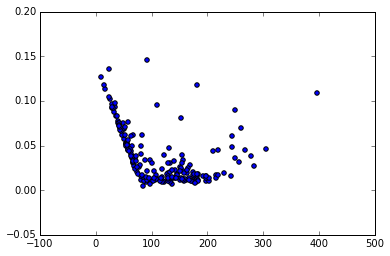

In [118]:
plt.scatter(test_labels, over_80_errs)

## Evaluating the best model

In [ ]:
RUN_NAME = 'CRPS-MODEL-3.0'
DATA_DIR = 'netdata'
ITERS = 100000
START_ITER = 0
MODEL_LOAD_PATH = None
PIC_WIDTH = 32
### Architectural Hyperparameters
DEPTH_1 = 20         # The output depth of the first convolutional layer
DEPTH_2 = 40         # The output depth of the second convolutional layer
DEPTH_3 = 80         # The output depth of the second convolutional layer
DEPTH_4 = 150        # The output depth of the second convolutional layer
DEPTH_5 = 150        # The output depth of the second convolutional layer
DEPTH_6 = 150        # The output depth of the second convolutional layer
NUM_HIDDEN = 400     # Number of hidden units in the hidden layer
NUM_OUTPUTS = 600    # Number of output classes in the softmax layer
KERNEL_X = 3         # The width of the convolution kernel (using same for 1st and 2nd layers)
KERNEL_Y = 3         # The height of the convolution kernel (using same for 1st and 2nd layers)
mu = 0.0001
LEARNING_RATE = 1e-4

REGULARIZE_BIAS = False


NUM_INPUTS = 3       # Number of input channels
NUM_REPS = 64
MBSIZE = 100

TRAIN_LABEL_NOISE_STD = 2.
TRAIN_LABEL_SMOOTHING_STD = 0.
DATA_AUGMENTATION = False

DATA_MEDIAN_FILTER = False
DATA_UNIT_VAR = False
VAL_PER = 1000
DROPOUT = 0.5
ALSO_MIN_RMSE = False
TEMP_DIR_PATH = '.'
TRAIN_ALL = False
FILTER_BY_LABEL = False
#########################################
NUM_INPUTS = 9       # Number of input channels
NUM_REPS = 144
TRAIN_LABEL_NOISE_STD = 1.
TRAIN_LABEL_SMOOTHING_STD = 2.
DATA_AUGMENTATION = True
RUN_NAME = 'AUG-EXP'

In [ ]:
MODEL_LOAD_PATH = 'AUG-EXP/model-9800'
best_cdfs = []

In [ ]:
graph = tf.Graph()
with graph.as_default():
    ####################################### INPUT/OUTPUT PLACEHOLDERS ##############################################
    x = tf.placeholder(tf.float32, shape=[None, PIC_WIDTH, PIC_WIDTH, NUM_INPUTS]) #Placeholder for the input images
    y_ = tf.placeholder(tf.float32, shape=[None, NUM_OUTPUTS]) #Placeholder for the label cdfs
    weights = tf.placeholder(tf.float32, shape=[None, 1])

    ####################################### FIRST CONVOLUTIONAL LAYER ##############################################
    # The weight tensor has dimensions [kernel_size_x, kernel_size_y, num_input_channels, num_output_channels]
    W_conv1 = weight_variable([KERNEL_X, KERNEL_Y, NUM_INPUTS, DEPTH_1])
    b_conv1 = bias_variable([DEPTH_1])
    #Take the input image, reshape it to a 4D tensor with dimensions: [_, image_width, image_height, num_channels]
    #x_image = tf.reshape(x, [-1,32,32,3])
    # Convolve with kernel -> add bias -> apply ReLU -> max pool 
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    ####################################### SECOND CONVOLUTIONAL LAYER ##############################################
    W_conv2 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_1, DEPTH_2])
    b_conv2 = bias_variable([DEPTH_2])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    ####################################### THIRD CONVOLUTIONAL LAYER ##############################################
    W_conv3 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_2, DEPTH_3])
    b_conv3 = bias_variable([DEPTH_3])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)

    ####################################### FOURTH CONVOLUTIONAL LAYER ##############################################
    W_conv4 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_3, DEPTH_4])
    #W_conv4 = weight_variable([2, 2, DEPTH_3, DEPTH_4]) #Modified this to support 5x5
    b_conv4 = bias_variable([DEPTH_4])

    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
    # ####################################### FIFTH CONVOLUTIONAL LAYER ##############################################
    #This layer uses a 1x1 convolution
    W_conv5 = weight_variable([1, 1, DEPTH_4, DEPTH_5])
    b_conv5 = bias_variable([DEPTH_5])

    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = tf.nn.avg_pool(h_conv5,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_pool5_flat = tf.reshape(h_pool5, [-1, DEPTH_6])

    ############################################### DROPOUT ##########################################################
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_pool5_flat, keep_prob)

    ############################################# SOFTMAX OUTPUT LAYER ###############################################
    W_fc2 = weight_variable([DEPTH_5, NUM_OUTPUTS])
    b_fc2 = bias_variable([NUM_OUTPUTS])

    y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

    #Cumulative sum
    y = cumsum(y_conv)
    ##################################### SETTING UP THE OPTIMISATION PROBLEM #####################################
    crps = tf.reduce_mean(tf.reduce_mean(tf.square(y - y_), 1)*weights) #y_ here should be the label cdfs
    ### Could add learning rate decay here - 1e-4 is the current learning rate
    loss = crps + mu*(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)
                    + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                    + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_fc2))
#     if REGULARIZE_BIAS:
#         loss += mu*(tf.nn.l2_loss(b_conv1) + tf.nn.l2_loss(b_conv2)
#                 + tf.nn.l2_loss(b_conv3) + tf.nn.l2_loss(b_conv4)
#                 + tf.nn.l2_loss(b_conv5) + tf.nn.l2_loss(b_fc2))

    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    mean_y = tf.reduce_mean(tf.reshape(y,(-1, NUM_REPS, NUM_OUTPUTS)), 1)
    mean_crps = tf.reduce_mean(tf.reduce_mean(tf.square(mean_y - y_), 1)*weights)

    mean_crps_summ = tf.scalar_summary("mean crps", mean_crps)
    crps_summ = tf.scalar_summary("crps", crps)

In [ ]:
X, y = batch(test[:,100:200], [])
best_cdfs = list(best_cdfs)
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    best_cdfs.extend(mean_y.eval(feed_dict={x:X, keep_prob: 1}))

best_cdfs = np.array(best_cdfs)
best_cdfs.shape

In [428]:
np.save('best_cdfs.npy', smooth_best_cdfs)
np.save('over_80_cdfs.npy', smooth_cdfs)
np.save('under_110_cdfs.npy', smooth_under_cdfs)
np.save('classifier_predictions.npy', class_pred)

In [427]:
class_pred[:10]

array([ 0.96363002,  0.39884675,  0.9598344 ,  0.27593374,  0.99998689,
        0.28982264,  0.81741428,  0.27842405,  0.9994418 ,  0.54476768], dtype=float32)

In [119]:
best_errs = np.mean(np.square(best_cdfs[:] - make_cdf(test_labels[:])), 1)

In [120]:
best_errs.mean()

0.02154622361472101

### Smooth the CDFs

In [215]:
width = 20
h = np.ones(width)/float(width)
smooth_best_cdfs = np.zeros_like(best_cdfs)
for i in range(best_cdfs.shape[0]):
    smoos = np.convolve(h,best_cdfs[i])
    smoos = smoos[width/2:-(width/2 - 1)]
    smoos[-(width/2):] = 1.
    smooth_best_cdfs[i,:] = smoos
best_errs = np.mean(np.square(smooth_best_cdfs[:] - make_cdf(test_labels[:])), 1)

In [216]:
smooth_best_cdfs.shape

(200, 600)

In [217]:
best_errs.mean()

0.021221292677961193

## Evaluating the classifier

In [497]:
RUN_NAME = 'CRPS-MODEL-3.0'
DATA_DIR = 'netdata'
ITERS = 100000
START_ITER = 0
MODEL_LOAD_PATH = None
PIC_WIDTH = 32
### Architectural Hyperparameters
DEPTH_1 = 8         # The output depth of the first convolutional layer
DEPTH_2 = 16         # The output depth of the second convolutional layer
DEPTH_3 = 20         # The output depth of the second convolutional layer
DEPTH_4 = 24        # The output depth of the second convolutional layer
DEPTH_5 = 30        # The output depth of the second convolutional layer
DEPTH_6 = 40        # The output depth of the second convolutional layer

NUM_OUTPUTS = 25    # Number of output classes in the softmax layer
KERNEL_X = 3         # The width of the convolution kernel (using same for 1st and 2nd layers)
KERNEL_Y = 3         # The height of the convolution kernel (using same for 1st and 2nd layers)
mu = 0.0001
LEARNING_RATE = 1e-4

REGULARIZE_BIAS = False

NUM_INPUTS = 9  
NUM_REPS = 144

TRAIN_LABEL_NOISE_STD = 2.
TRAIN_LABEL_SMOOTHING_STD = 0.
DATA_AUGMENTATION = True
DIASTOLE = False

###########################################
NUM_INPUTS = 9       # Number of input channels
NUM_OUTPUTS = 2
NUM_REPS = 144
TRAIN_LABEL_NOISE_STD = 0.0001
TRAIN_LABEL_SMOOTHING_STD = 0.
LEARNING_RATE = 1e-3
mu = 0.05
DATA_AUGMENTATION = True
RUN_NAME = 'TWO-CLASS-EXP'
DEPTH_1 = 4         # The output depth of the first convolutional layer
DEPTH_2 = 4         # The output depth of the second convolutional layer
DEPTH_3 = 4         # The output depth of the second convolutional layer
DEPTH_4 = 2        # The output depth of the second convolutional layer
DEPTH_5 = 2        # The output depth of the second convolutional layer
DEPTH_6 = 2   

In [540]:
graph = tf.Graph()
with graph.as_default():
    ####################################### INPUT/OUTPUT PLACEHOLDERS ##############################################
    x = tf.placeholder(tf.float32, shape=[None, PIC_WIDTH, PIC_WIDTH, NUM_INPUTS]) #Placeholder for the input images
    y_ = tf.placeholder(tf.float32, shape=[None, NUM_OUTPUTS]) #Placeholder for the label cdfs
    ####################################### FIRST CONVOLUTIONAL LAYER ##############################################
    # The weight tensor has dimensions [kernel_size_x, kernel_size_y, num_input_channels, num_output_channels]
    W_conv1 = weight_variable([KERNEL_X, KERNEL_Y, NUM_INPUTS, DEPTH_1])
    b_conv1 = bias_variable([DEPTH_1])
    #Take the input image, reshape it to a 4D tensor with dimensions: [_, image_width, image_height, num_channels]
    #x_image = tf.reshape(x, [-1,32,32,3])
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    ####################################### SECOND CONVOLUTIONAL LAYER ##############################################
    W_conv2 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_1, DEPTH_2])
    b_conv2 = bias_variable([DEPTH_2])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    ####################################### THIRD CONVOLUTIONAL LAYER ##############################################
    W_conv3 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_2, DEPTH_3])
    b_conv3 = bias_variable([DEPTH_3])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    ####################################### FOURTH CONVOLUTIONAL LAYER ##############################################
    W_conv4 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_3, DEPTH_4])
    b_conv4 = bias_variable([DEPTH_4])

    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
    # ####################################### FIFTH CONVOLUTIONAL LAYER ##############################################
    #This layer uses a 1x1 convolution
    W_conv5 = weight_variable([1, 1, DEPTH_4, DEPTH_5])
    b_conv5 = bias_variable([DEPTH_5])

    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = tf.nn.avg_pool(h_conv5,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_pool5_flat = tf.reshape(h_pool5, [-1, DEPTH_5])
    ############################################### DROPOUT ##########################################################
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_pool5_flat, keep_prob)
    ############################################# SOFTMAX OUTPUT LAYER ###############################################
    W_fc2 = weight_variable([DEPTH_5, NUM_OUTPUTS])
    b_fc2 = bias_variable([NUM_OUTPUTS])

    y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    ##################################### SETTING UP THE OPTIMISATION PROBLEM #####################################
    cross_entropy = -tf.reduce_sum(y_*tf.log(y+1e-12))
    loss = cross_entropy + mu*(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)
                                + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                                + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_fc2))

    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    xentrop_summ = tf.scalar_summary("Cross Entropy", loss)
    accuracy_summ = tf.scalar_summary("Accuracy", accuracy)

In [541]:
MODEL_LOAD_PATH = 'TWO-CLASS-EXP/model-13000'

In [542]:
predictions = []

In [543]:
predictions = []
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    for i in range(200):
        if i%40 == 0:
            print 'Patient ', i
        Xt,yt = batch(test[:,i:i+1], [])
        #predictions = list(predictions)
        pred = session.run([y], feed_dict={x: Xt, keep_prob: 1.0})[0]
        pred = np.mean(pred, axis=0)
        #pred = pred[1]
        predictions.append(pred)
    predictions = np.array(predictions)

Patient  0
Patient  40
Patient  80
Patient  120
Patient  160


In [544]:
class_pred = predictions[:,1]

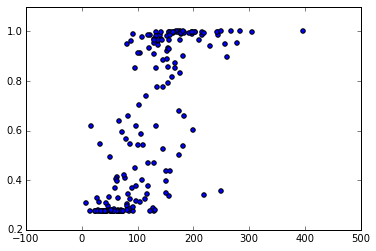

In [545]:
plt.scatter(test_labels, class_pred)

In [68]:
fps = []
fns = []
accs = []
for thresh in np.linspace(0.2, 0.95, 50):
    #thresh = #0.307
    mask = (test_labels < 100)*(class_pred > thresh)
    false_pos = test_labels[mask].shape[0]/float(np.sum(test_labels>100))

    mask = (test_labels > 100)*(class_pred < thresh)
    false_negative = test_labels[mask].shape[0]/float(np.sum(test_labels>100))
    accuracy = np.sum(class_pred > thresh)/float(np.sum(test_labels>100))
    accs.append(accuracy)
    fps.append(false_pos)
    fns.append(false_negative) #accuracy*(1 - (false_pos/float(np.sum(yt>100))))

In [78]:
thresh = 0.7
mask = (test_labels < 100)*(class_pred > thresh)
false_pos = test_labels[mask].shape[0]/float(np.sum(test_labels>100))

mask = (test_labels > 100)*(class_pred < thresh)
false_negative = test_labels[mask].shape[0]/float(np.sum(test_labels>100))
accuracy = np.sum(class_pred > thresh)/float(np.sum(test_labels>100))

In [79]:
false_pos, false_negative, accuracy

(0.03669724770642202, 0.25688073394495414, 0.77981651376146788)

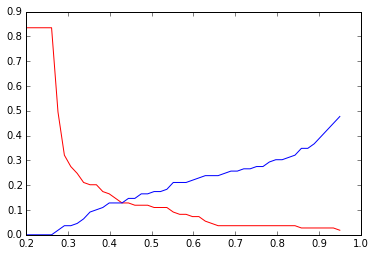

In [64]:
plt.plot(np.linspace(0.2, 0.95, 50), fps, 'r')
plt.plot(np.linspace(0.2, 0.95, 50), fns, 'b')

In [172]:
jerrs = []
for thresh in np.linspace(0.3,0.96,50):
    joint_cdfs = np.concatenate((smooth_best_cdfs[class_pred < thresh],smooth_cdfs[class_pred > thresh]))
    jerrs.append(np.mean(np.square(joint_cdfs[:] - make_cdf(test_labels[:])), 1))

In [124]:
joint_errs = []
for thresh in np.linspace(0.3,0.96,50):
    alpha = np.sum(class_pred < thresh)/200.
    joint_err = alpha*best_errs[class_pred < thresh].mean() + (1-alpha)*over_80_errs[class_pred > thresh].mean()
    joint_errs.append(joint_err)

## Use point estimates rather than classifier predictions

In [496]:
best_errs.mean()

0.021221292677961193

In [495]:
best = (600, 0)
best_err = 20.
for ub in range(100,300,2):
    for lb in range(0,100,2):
        part1 = smooth_best_cdfs.copy()
        part1[pests < lb] = 0.0
        part1[pests > ub] = 0.0

        part2 = smooth_cdfs.copy()
        part2[pests < ub] = 0.0

        part3 = smooth_under_cdfs.copy()
        part3[pests > lb] = 0.0

        total_cdfs = part1 + part2 + part3 #smooth_best_cdfs*(class_pred < thresh)+smooth_cdfs*(class_pred > thresh)
        err = np.mean(np.mean(np.square(total_cdfs[:] - make_cdf(test_labels[:])), 1))
        if err < best_err:
            best = (ub, lb)
            best_err = err

best, best_err

((178, 0), 0.020100129929578835)

In [493]:
p_errs = np.mean(np.square(total_cdfs[:] - make_cdf(test_labels[:])), 1)

In [494]:
p_errs.mean()

0.021239672772933559

### +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [535]:
ub = 1.
lb = 0.
es = []
for lb in np.linspace(0.0, 1., 50): 
    part1 = smooth_best_cdfs.copy()
    part1[class_pred < lb] = 0.0
    part1[class_pred > ub] = 0.0

    part2 = smooth_cdfs.copy()
    part2[class_pred < ub] = 0.0

    part3 = smooth_under_cdfs.copy()
    part3[class_pred > lb] = 0.0

    total_cdfs = part1 + part2 + part3 #smooth_best_cdfs*(class_pred < thresh)+smooth_cdfs*(class_pred > thresh)
    e = np.mean(np.mean(np.square(total_cdfs[:] - make_cdf(test_labels[:])), 1))
    es.append(e)

In [537]:
np.argmin(es)

13

In [538]:
es[13]

0.021212220096030167

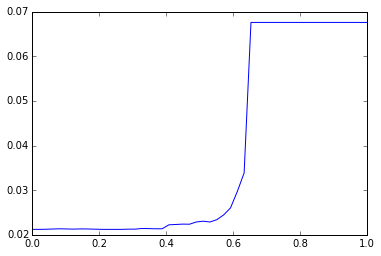

In [536]:
plt.plot(np.linspace(0,1,50), es)

In [531]:
np.argmin(es)

27

In [523]:
t_errs = np.mean(np.square(total_cdfs[:] - make_cdf(test_labels[:])), 1)

In [509]:
t_errs.mean()

0.021221292677961193

In [524]:
t_errs.mean()

0.021303095348607623

In [417]:
np.sum(class_pred < 0.277)

42

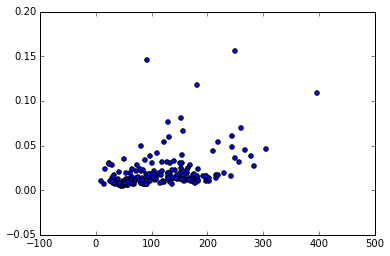

In [378]:
plt.scatter(test_labels, t_errs)

In [282]:
t_errs[test_labels < 100].mean(), t_errs[test_labels > 100].mean()

(0.014590426239965702, 0.024811236418202258)

In [283]:
best_errs[test_labels < 100].mean(), best_errs[test_labels > 100].mean()

(0.014077640236271781, 0.027185259395334917)

In [271]:
joint_cdfs = np.zeros_like(best_cdfs)
for i in range(200):
    alpha = class_pred[i]**3#(class_pred[i]**4)/(class_pred[i]**4 + (1-class_pred[i])**4)
    joint_cdfs[i,:] = (1 - alpha)*smooth_best_cdfs[i] + (alpha)*smooth_cdfs[i]

joint_cdfs.shape

(200, 600)

In [272]:
soft_errs = np.mean(np.square(joint_cdfs[:] - make_cdf(test_labels[:])), 1)

In [279]:
t_errs.mean(), soft_errs.mean()

(0.020160767787104624, 0.020382730737500028)

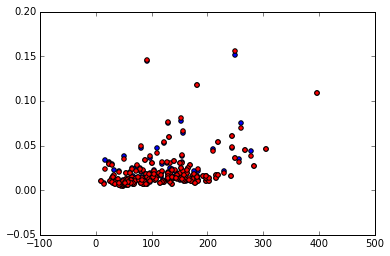

In [280]:
plt.scatter(test_labels, soft_errs)
plt.scatter(test_labels, t_errs, c='r')

In [156]:
mask = (class_pred > 0.75)*(test_labels < 100)
false_pos = test_labels[mask]

In [157]:
false_pos

array([ 88.7,  95.4,  80.7,  91. ])

In [155]:
test_labels[best_errs > 0.05]

array([ 157. ,  218.4,  128.9,  244.1,  397.1,  284. ,  131. ,  305.5,
        277.6,  268.3,  209.9,  257. ,  122.5,  249.7,  250. ,  260.6,
        182. ,   91. ])

In [154]:
test_labels[total_errs > 0.05]

array([ 243.3,  172.7,   50.6,  230.5,  100.1,  158.9,  104.8,   62. ,
         58.5,   51.8,  215.9,   96.5])

In [149]:
false_pos

array([ 88.7,  95.4,  80.7,  91. ])

In [284]:
thresh = 0.75
total_errs = np.concatenate((best_errs[class_pred < thresh],over_80_errs[class_pred > thresh]))

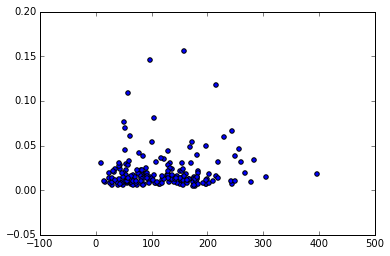

In [285]:
plt.scatter(test_labels, total_errs)

In [286]:
total_errs.mean()

0.020160767787104624

In [137]:
total_errs[test_labels<100].mean(), total_errs[test_labels>100].mean()

(0.019347035980824837, 0.020840121863101791)

In [136]:
best_errs[test_labels<100].mean(), best_errs[test_labels>100].mean()

(0.014077640233637216, 0.027185259406250308)

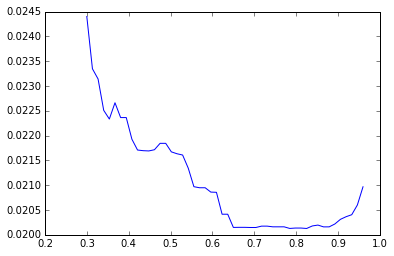

In [125]:
plt.plot(np.linspace(0.3,0.96,50), joint_errs)

In [127]:
np.linspace(0.3,0.96,50)[39]

0.8253061224489795

In [128]:
np.min(joint_errs), np.argmin(joint_errs)

(0.020127561795954159, 39)

In [129]:
best_errs.mean() - np.min(joint_errs)

0.0010937308867571896

### ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

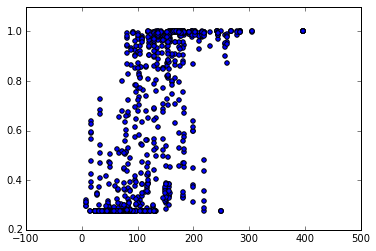

In [59]:
plt.scatter(yt, predictions[:,1])

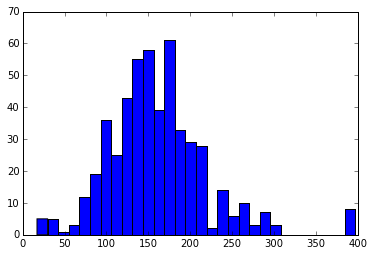

In [118]:
_,_,_ = plt.hist(yt[predictions[:,1] > 0.5], bins=30)

In [125]:
fps = []
fns = []
for thresh in np.linspace(0.2, 0.95, 50):
    #thresh = #0.307
    mask = (yt[:,0] < 100)*(predictions[:,1] > thresh)
    false_pos = yt[mask].shape[0]/float(np.sum(yt>100))

    mask = (yt[:,0] > 100)*(predictions[:,1] < thresh)
    false_negative = yt[mask].shape[0]/float(np.sum(yt>100))

    accuracy = np.sum(predictions[:,1] > thresh)/float(np.sum(yt>100))
    fps.append(false_pos)
    fns.append(false_negative) #accuracy*(1 - (false_pos/float(np.sum(yt>100))))

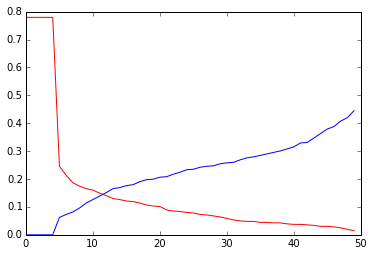

In [126]:
plt.plot(fps, 'r')
plt.plot(fns, 'b')

In [ ]:
mask = (yt[:,0] < 100)*(predictions[:,1] > thresh)
false_pos = yt[mask].shape[0]

In [119]:
np.sum(predictions[:,1] > 0.5)

505

In [112]:
np.argmax(score)

7

In [85]:
mask = (yt[:,0] < 100)*(predictions[:,1] > 0.5)

In [86]:
yt[mask].shape

(58, 1)

(array([  57.,   86.,   12.,    7.,   76.,    0.,  109.,    3.,   44.,
          47.,   50.,   35.,   19.,   16.,   34.,    7.,  112.,   13.,
          13.,    1.,  130.,    3.,   53.,   41.,   32.]),
 array([  0.  ,   0.96,   1.92,   2.88,   3.84,   4.8 ,   5.76,   6.72,
          7.68,   8.64,   9.6 ,  10.56,  11.52,  12.48,  13.44,  14.4 ,
         15.36,  16.32,  17.28,  18.24,  19.2 ,  20.16,  21.12,  22.08,
         23.04,  24.  ]),
 <a list of 25 Patch objects>)

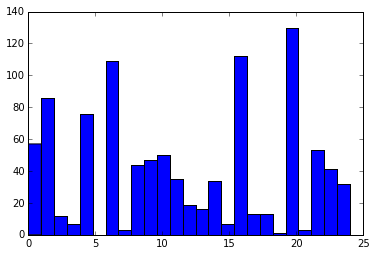

In [31]:
plt.hist(predictions[0], bins=25)

In [250]:
test_classes = make_class_label(yt)
test_classes.shape

(1000, 10)

In [254]:
t_class = np.argmax(test_classes, axis=1)
t_class[:10]

array([5, 0, 4, 2, 8, 7, 6, 5, 6, 0])

In [255]:
predictions[0][:10]

array([3, 0, 4, 2, 8, 8, 5, 3, 9, 1])

In [259]:
accs = [np.mean(predictions[0][t_class == i] == t_class[t_class == i]) for i in range(10)]

In [265]:
accs

[0.58878504672897192,
 0.51470588235294112,
 0.29496402877697842,
 0.43181818181818182,
 0.27027027027027029,
 0.25925925925925924,
 0.24183006535947713,
 0.13636363636363635,
 0.67692307692307696,
 0.60256410256410253]

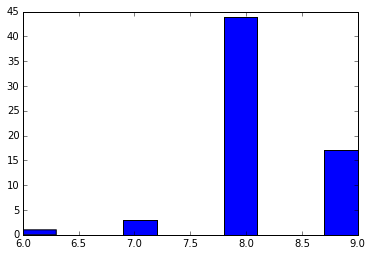

In [273]:
counts, scores, _ = plt.hist(predictions[0][t_class == 8])

### Run test cases through this classifier

In [408]:
predictions = []

In [409]:
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    for i in range(200):
        if i%50 == 0:
            print 'Case %d' % i
        X, test_labs = batch(test[:,i:i+1], [])
        pred = y.eval(feed_dict={x:X, keep_prob: 1.})
        predictions.extend(np.mean(pred, axis=0))

predictions = np.array(predictions)

Case 0
Case 50
Case 100
Case 150


In [410]:
predictions.shape

(2000,)

In [313]:
np.sum(predictions)

200.0

In [411]:
predictions = np.reshape(predictions, (200, 10))
predictions[0]

array([  2.17667800e-16,   6.17813846e-15,   2.93096519e-11,
         2.95156859e-08,   7.89937330e-05,   1.26642117e-03,
         1.23804603e-02,   2.26404592e-01,   6.18132234e-01,
         1.41737312e-01], dtype=float32)

In [419]:
soft_predictions = []
for i in range(200):
    soft_predictions.append(np.sum([predictions[i][j]*j for j in range(10)]))
#predictions = np.mean(predictions[i] , axis=1)

In [420]:
soft_predictions = np.array(soft_predictions)
soft_predictions.shape

(200,)

In [323]:
test_labels[predictions == 9]

array([ 243.3,  397.1,  215. ,  284. ,  169.5,  305.5,  241.7,  181.3,
        203.6,  268.3,  257. ,  249.7,  109.4,  250. ,  182. ,  219.3])

In [382]:
errs = [errors[predictions == i].mean() for i in range(10)]
errs

[0.32123667660455996,
 0.27898278870585402,
 0.27160360853072413,
 0.23671157885254152,
 0.21183617566479318,
 0.1692951492046551,
 0.14697928813581185,
 0.10724855029399888,
 0.098133146040374847,
 0.064906080054163609]

In [384]:
b_errs = [best_errs[predictions == i].mean() for i in range(10)]
b_errs

[0.012319645175615091,
 0.014281586093096234,
 0.0078595513444006775,
 0.016847867230656361,
 0.020172668462459905,
 0.01535038285718923,
 0.01725590908379444,
 0.033737819610445509,
 0.02459551709208524,
 0.055692864171687666]

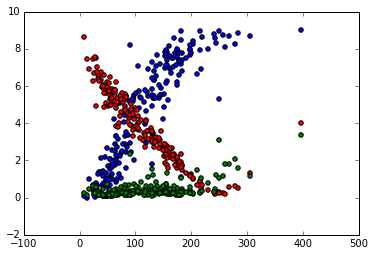

In [423]:
plt.scatter(test_labels, soft_predictions)
plt.scatter(test_labels, 20*errors, c='r')
plt.scatter(test_labels, 20*best_errs, c='g')

In [489]:
mask = (soft_predictions > 8.7)*(pests > 180)
test_labels[mask]

array([ 397.1,  215. ,  284. ,  241.7,  257. ,  250. ,  182. ])

In [490]:
errors[mask].mean()

0.055545040654554491

In [491]:
best_errs[mask].mean()

0.063604920174532259

In [ ]:
test_classes = make_class_label(test_labels)
test_classes.shape

## ++++++++++++++++++++++++++++ END CLASSIFIER ++++++++++++++++++++++++++++++

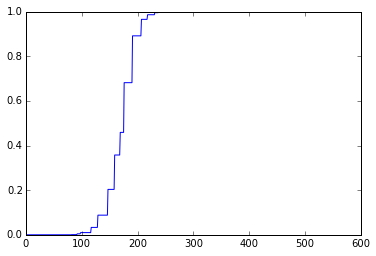

In [492]:
plt.plot(best_cdfs[0])

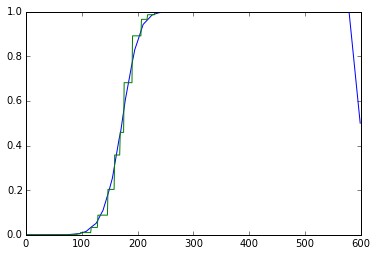

In [511]:
h = np.ones(40)/40.
smoos = np.convolve(h,best_cdfs[0])
plt.plot(smoos[20:-19])
plt.plot(best_cdfs[0])

In [548]:
#width = 60
smoothed_errs = []
for width in range(4,80,2):
    h = np.ones(width)/float(width)
    smooth_cdfs = np.zeros_like(best_cdfs)
    for i in range(best_cdfs.shape[0]):
        smoos = np.convolve(h,best_cdfs[i])
        smoos = smoos[width/2:-(width/2 - 1)]
        smoos[-(width/2):] = 1.
        smooth_cdfs[i,:] = smoos
    smooth_errors = np.mean(np.square(smooth_cdfs[:] - make_cdf(test_labels[:])), 1)
    smoothed_errs.append(smooth_errors.mean())
    #smooth_errors = np.mean(np.square(smooth_cdfs[:] - make_cdf(test_labels[:])), 1)
    #smooth_errors.mean(), best_errs.mean()

In [288]:
import pandas as pd

In [290]:
cd ..

/Users/omakhlouf/Desktop/Data Science Bowl


In [291]:
valid = pd.read_csv('validate.csv')
valid_labels = valid.as_matrix()
valid_labels.shape

(200, 3)

In [292]:
valid_labels = valid_labels[:,1:]
valid_labels.shape

(200, 2)

In [293]:
cd kaggle-dsb/

/Users/omakhlouf/Desktop/Data Science Bowl/kaggle-dsb


In [295]:
test_labels[:4]

array([ 175.7,  107.3,   88.7,   30.7])

In [296]:
valid_labels[:2]

array([[ 104.3,  212.5],
       [  87.2,  203.8]])

In [297]:
swapped = np.zeros_like(valid_labels)
swapped[:,0] = valid_labels[:,1]
swapped[:,1] = valid_labels[:,0]

In [298]:
valid_labels= swapped.reshape((400,1))

In [301]:
test_labels.shape

(200,)

In [303]:
np.save('labels_lboard.npy',valid_labels[:,0])

In [299]:
valid_labels[:4]

array([[ 212.5],
       [ 104.3],
       [ 203.8],
       [  87.2]])

In [20]:
cd kaggle-dsb

/Users/omakhlouf/Desktop/Data Science Bowl/kaggle-dsb


In [22]:
from helpers import *
from nnutils import *

(array([  9.,   9.,  19.,  41.,  37.,  36.,  18.,  21.,  18.,  18.,  25.,
         20.,  23.,  17.,  19.,  18.,  11.,  12.,   8.,   4.,   3.,   3.,
          2.,   5.,   2.,   0.,   0.,   0.,   0.,   2.]),
 array([   3.93 ,   15.699,   27.468,   39.237,   51.006,   62.775,
          74.544,   86.313,   98.082,  109.851,  121.62 ,  133.389,
         145.158,  156.927,  168.696,  180.465,  192.234,  204.003,
         215.772,  227.541,  239.31 ,  251.079,  262.848,  274.617,
         286.386,  298.155,  309.924,  321.693,  333.462,  345.231,  357.   ]),
 <a list of 30 Patch objects>)

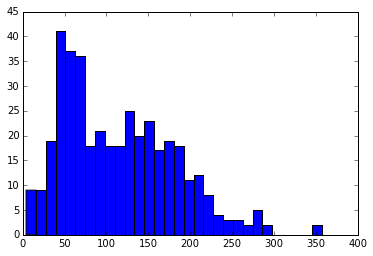

In [68]:
plt.hist(valid_labels, bins=30)

In [69]:
valid_errs = np.mean(np.square(sub_cdfs[:] - make_cdf(valid_labels[:])), 1)

In [122]:
np.sum(mask)

163

In [131]:
mask = (valid_labels[:,0] < 100)#*(valid_labels[:,0] < 200)
valid_errs[mask].mean(), np.sum(mask)

(0.013362621737174733, 193)

In [135]:
mask = (valid_labels[:,0] > 100)#*(valid_labels[:,0] < 200)
valid_errs[mask].mean(), np.sum(mask)

(0.026988574884343357, 207)

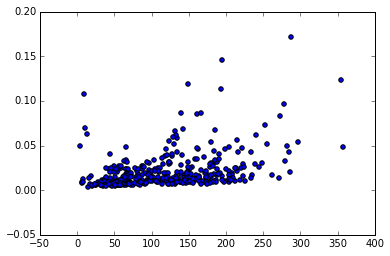

In [72]:
plt.scatter(valid_labels, valid_errs)

## +++++++++++++++++++++++++++ Load SHIFT-AUG-EXP +++++++++++++++++++++++++++

In [175]:
RUN_NAME = 'CRPS-MODEL-3.0'
DATA_DIR = 'netdata'
ITERS = 100000
START_ITER = 0
MODEL_LOAD_PATH = None
PIC_WIDTH = 32
### Architectural Hyperparameters
DEPTH_1 = 20         # The output depth of the first convolutional layer
DEPTH_2 = 40         # The output depth of the second convolutional layer
DEPTH_3 = 80         # The output depth of the second convolutional layer
DEPTH_4 = 150        # The output depth of the second convolutional layer
DEPTH_5 = 150        # The output depth of the second convolutional layer
DEPTH_6 = 150        # The output depth of the second convolutional layer
NUM_HIDDEN = 400     # Number of hidden units in the hidden layer
NUM_OUTPUTS = 600    # Number of output classes in the softmax layer
KERNEL_X = 3         # The width of the convolution kernel (using same for 1st and 2nd layers)
KERNEL_Y = 3         # The height of the convolution kernel (using same for 1st and 2nd layers)
mu = 0.0001
LEARNING_RATE = 1e-4

REGULARIZE_BIAS = False

NUM_INPUTS = 3       # Number of input channels
NUM_REPS = 64


TRAIN_LABEL_NOISE_STD = 2.
TRAIN_LABEL_SMOOTHING_STD = 0.
DATA_AUGMENTATION = True
ENLARGED = False
SHIFT = False
DIASTOLE = False

DATA_MEDIAN_FILTER = False
WEIGHTS_PATH = None

##### The actual experiment I was using
NUM_INPUTS = 9       # Number of input channels
DEPTH_1 = 10         # The output depth of the first convolutional layer
DEPTH_2 = 20         # The output depth of the second convolutional layer
DEPTH_3 = 40         # The output depth of the second convolutional layer
DEPTH_4 = 40        # The output depth of the second convolutional layer
DEPTH_5 = 60        # The output depth of the second convolutional layer
DEPTH_6 = 60        # The output depth of the second convolutional layer
NUM_REPS = 144
TRAIN_LABEL_NOISE_STD = .02
TRAIN_LABEL_SMOOTHING_STD = .02
DATA_AUGMENTATION = True
mu = 0.0002
#ENLARGED = True
DIASTOLE = True
RUN_NAME = 'DIA-ONLY5'

In [176]:
graph = tf.Graph()
with graph.as_default():
    ####################################### INPUT/OUTPUT PLACEHOLDERS ##############################################
    x = tf.placeholder(tf.float32, shape=[None, PIC_WIDTH, PIC_WIDTH, NUM_INPUTS]) #Placeholder for the input images
    y_ = tf.placeholder(tf.float32, shape=[None, NUM_OUTPUTS]) #Placeholder for the label cdfs
    weights = tf.placeholder(tf.float32, shape=[None, 1])

    ####################################### FIRST CONVOLUTIONAL LAYER ##############################################
    # The weight tensor has dimensions [kernel_size_x, kernel_size_y, num_input_channels, num_output_channels]
    W_conv1 = weight_variable([KERNEL_X, KERNEL_Y, NUM_INPUTS, DEPTH_1])
    b_conv1 = bias_variable([DEPTH_1])
    #Take the input image, reshape it to a 4D tensor with dimensions: [_, image_width, image_height, num_channels]
    #x_image = tf.reshape(x, [-1,32,32,3])
    # Convolve with kernel -> add bias -> apply ReLU -> max pool 
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    ####################################### SECOND CONVOLUTIONAL LAYER ##############################################
    W_conv2 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_1, DEPTH_2])
    b_conv2 = bias_variable([DEPTH_2])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    ####################################### THIRD CONVOLUTIONAL LAYER ##############################################
    W_conv3 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_2, DEPTH_3])
    b_conv3 = bias_variable([DEPTH_3])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)

    ####################################### FOURTH CONVOLUTIONAL LAYER ##############################################
    W_conv4 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_3, DEPTH_4])
    b_conv4 = bias_variable([DEPTH_4])

    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
    # ####################################### FIFTH CONVOLUTIONAL LAYER ##############################################
    #This layer uses a 1x1 convolution
    W_conv5 = weight_variable([1, 1, DEPTH_4, DEPTH_5])
    b_conv5 = bias_variable([DEPTH_5])

    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = tf.nn.avg_pool(h_conv5,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_pool5_flat = tf.reshape(h_pool5, [-1, DEPTH_6])

    ############################################### DROPOUT ##########################################################
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_pool5_flat, keep_prob)

    ############################################# SOFTMAX OUTPUT LAYER ###############################################
    W_fc2 = weight_variable([DEPTH_5, NUM_OUTPUTS])
    b_fc2 = bias_variable([NUM_OUTPUTS])

    y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

    #Cumulative sum
    y = cumsum(y_conv)
    ##################################### SETTING UP THE OPTIMISATION PROBLEM #####################################
    crps = tf.reduce_mean(tf.reduce_mean(tf.square(y - y_), 1)*weights) #y_ here should be the label cdfs
    ### Could add learning rate decay here - 1e-4 is the current learning rate
    loss = crps + mu*(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)
                    + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                    + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_fc2))
    if REGULARIZE_BIAS:
        loss += mu*(tf.nn.l2_loss(b_conv1) + tf.nn.l2_loss(b_conv2)
                + tf.nn.l2_loss(b_conv3) + tf.nn.l2_loss(b_conv4)
                + tf.nn.l2_loss(b_conv5) + tf.nn.l2_loss(b_fc2))

    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    mean_y = tf.reduce_mean(tf.reshape(y,(-1, NUM_REPS, NUM_OUTPUTS)), 1)
    mean_crps = tf.reduce_mean(tf.reduce_mean(tf.square(mean_y - y_), 1)*weights)

    mean_crps_summ = tf.scalar_summary("mean crps", mean_crps)
    crps_summ = tf.scalar_summary("crps", crps)

In [177]:
MODEL_LOAD_PATH = 'DIA-ONLY5/model-111000'

In [178]:
cdfs = []

In [181]:
#Do this 50 at a time -> 0:50, 50:100, 100:150, 150:200
X, y = batch(test[:,100:200], [])
cdfs = list(cdfs)
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    cdfs.extend(mean_y.eval(feed_dict={x:X, keep_prob: 1}))

cdfs = np.array(cdfs)

In [182]:
cdfs.shape

(200, 600)

In [183]:
shift_errs = np.mean(np.square(cdfs[:] - make_cdf(test_labels[:])), 1)

In [197]:
shift_errs[::2][test_labels[::2] > 80].mean()

0.026222164341912418

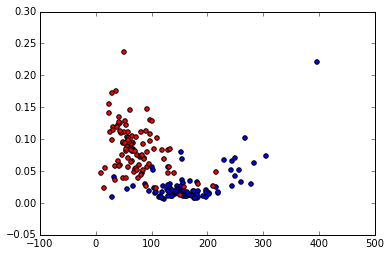

In [202]:
plt.scatter(test_labels[::2], shift_errs[::2])
plt.scatter(test_labels[1::2], shift_errs[1::2], c='r')

In [199]:
mask = (test_labels > 120)*(test_labels < 200)
shift_errs[mask].mean(), np.sum(mask)

(0.022627842101478706, 74)

## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [27]:
sub = pd.read_csv('smooth_sub2.csv')

In [28]:
sub_cdfs = sub.as_matrix()
sub_cdfs.shape

(400, 601)

In [29]:
sub_cdfs = sub_cdfs[:, 1:]
sub_cdfs.shape

(400, 600)

In [598]:
width = 20
h = np.ones(width)/float(width)
smooth_cdfs = np.zeros_like(sub_cdfs)
for i in range(sub_cdfs.shape[0]):
    smoos = np.convolve(h,sub_cdfs[i])
    smoos = smoos[width/2:-(width/2 - 1)]
    smoos[-(width/2):] = 1.
    smooth_cdfs[i,:] = smoos
    
smooth_cdfs.shape

(400, 600)

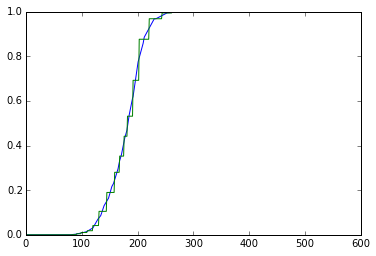

In [601]:
plt.plot(smooth_cdfs[2])
plt.plot(sub_cdfs[2])

In [602]:
new_sub = prepare_submission(np.array(smooth_cdfs))
new_sub.to_csv('smooth_sub2.csv')

In [555]:
width = 20
h = np.ones(width)/float(width)
smooth_cdfs = np.zeros_like(best_cdfs)
for i in range(best_cdfs.shape[0]):
    smoos = np.convolve(h,best_cdfs[i])
    smoos = smoos[width/2:-(width/2 - 1)]
    smoos[-(width/2):] = 1.
    smooth_cdfs[i,:] = smoos
smooth_errors = np.mean(np.square(smooth_cdfs[:] - make_cdf(test_labels[:])), 1)
smoothed_errs.append(smooth_errors.mean())

In [566]:
uncertainty = np.array([pdfs[i].std() for i in range(200)])

In [581]:
uncertain_cdfs = best_cdfs[uncertainty > 0.022]
uncertain_cdfs_smoos = smooth_cdfs[uncertainty > 0.022]

In [589]:
smooth_errors[uncertainty > 0.022].mean(), best_errs[uncertainty > 0.022].mean()

(0.031015488607771008, 0.03224022037628526)

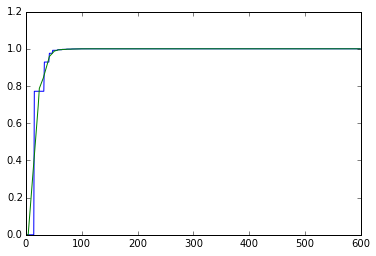

In [590]:
plt.plot(uncertain_cdfs[5])
plt.plot(uncertain_cdfs_smoos[5])

In [560]:
pdfs = np.diff(best_cdfs, axis=1)
pdfs.shape

(200, 599)

In [552]:
np.argmin(smoothed_errs), smoothed_errs[8]

(8, 0.021221292682711348)

In [554]:
best_errs.mean() - smoothed_errs[8]

0.00032493093200966147

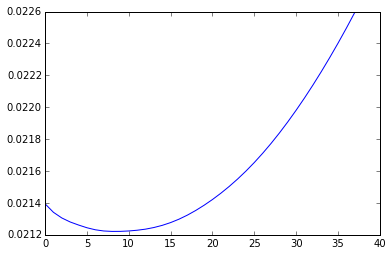

In [549]:
plt.plot(smoothed_errs)

In [545]:
len(range(4,80,2))

38

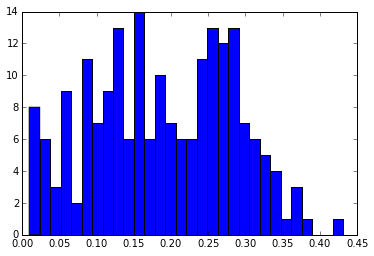

In [535]:
smooth_errors = np.mean(np.square(smooth_cdfs[:] - make_cdf(test_labels[:])), 1)
counts,scores,_ = plt.hist(errors, bins=30)

In [536]:
smooth_errors.mean()

0.021352636478102066

In [531]:
best_errs.mean()

0.02154622361472101

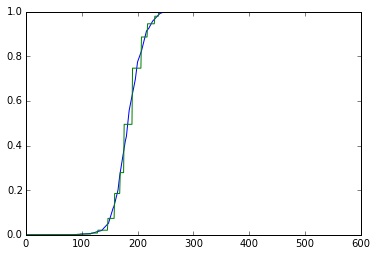

In [559]:
case = 30
plt.plot(smooth_cdfs[case])
plt.plot(best_cdfs[case])

In [508]:
np.mean(np.square(cdfs[0] - make_cdf(test_labels[0:1])[0]))

0.088187763661251001

In [515]:
np.mean(np.square(prop_smoos - make_cdf(test_labels[0:1])[0]))

0.010311087437755788

In [80]:
reduced_test = test[:, test_labels>240, :,:,:,:]
reduced_train = train[:, train_labels>240, :,:,:,:]
reduced_test_labels = test_labels[test_labels>240]
reduced_train_labels = train_labels[train_labels>240]
reduced_test.shape, reduced_train.shape

((3, 12, 2, 8, 32, 32), (3, 35, 2, 8, 32, 32))

In [471]:
test_labels[::2].shape

(100,)

In [82]:
rbatchdata, rbatchlabels, _ = minibatch(reduced_train, reduced_train_labels, size=50)
rbatchdata.shape, rbatchlabels.shape

((50, 32, 32, 9), (50, 1))

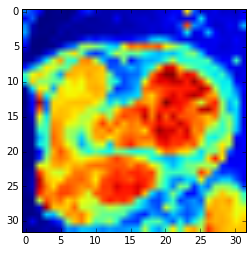

In [95]:
case = 1
i = 0
plt.imshow(rbatchdata[case, :, :, i])#.mean()

In [436]:
len(train_labels)

800

In [75]:
test[:, test_labels>150, :,:,:,:].shape

(3, 68, 2, 8, 32, 32)

In [38]:
test.shape

(3, 200, 2, 8, 32, 32)

In [37]:
train.shape

(3, 800, 2, 8, 32, 32)

In [20]:
RUN_NAME = 'CRPS-MODEL-3.0'
DATA_DIR = 'netdata'
ITERS = 100000
START_ITER = 0
MODEL_LOAD_PATH = None
PIC_WIDTH = 32
### Architectural Hyperparameters
DEPTH_1 = 20         # The output depth of the first convolutional layer
DEPTH_2 = 40         # The output depth of the second convolutional layer
DEPTH_3 = 80         # The output depth of the second convolutional layer
DEPTH_4 = 150        # The output depth of the second convolutional layer
DEPTH_5 = 150        # The output depth of the second convolutional layer
DEPTH_6 = 150        # The output depth of the second convolutional layer
NUM_HIDDEN = 400     # Number of hidden units in the hidden layer
NUM_OUTPUTS = 600    # Number of output classes in the softmax layer
KERNEL_X = 3         # The width of the convolution kernel (using same for 1st and 2nd layers)
KERNEL_Y = 3         # The height of the convolution kernel (using same for 1st and 2nd layers)
mu = 0.0001
LEARNING_RATE = 1e-4

REGULARIZE_BIAS = False

NUM_INPUTS = 3       # Number of input channels
NUM_REPS = 64


TRAIN_LABEL_NOISE_STD = 2.
TRAIN_LABEL_SMOOTHING_STD = 0.
DATA_AUGMENTATION = True
ENLARGED = False
SHIFT = False
DIASTOLE = False

DATA_MEDIAN_FILTER = False
WEIGHTS_PATH = None

##### The actual experiment I was using
NUM_INPUTS = 9       # Number of input channels
NUM_REPS = 144
TRAIN_LABEL_NOISE_STD = 0.0001
TRAIN_LABEL_SMOOTHING_STD = 0.
DATA_AUGMENTATION = True
SHIFT = True
RUN_NAME = 'NEW-SHIFT-AUG-EXP'

In [21]:
graph = tf.Graph()
with graph.as_default():
    ####################################### INPUT/OUTPUT PLACEHOLDERS ##############################################
    x = tf.placeholder(tf.float32, shape=[None, PIC_WIDTH, PIC_WIDTH, NUM_INPUTS]) #Placeholder for the input images
    y_ = tf.placeholder(tf.float32, shape=[None, NUM_OUTPUTS]) #Placeholder for the label cdfs
    weights = tf.placeholder(tf.float32, shape=[None, 1])

    ####################################### FIRST CONVOLUTIONAL LAYER ##############################################
    # The weight tensor has dimensions [kernel_size_x, kernel_size_y, num_input_channels, num_output_channels]
    W_conv1 = weight_variable([KERNEL_X, KERNEL_Y, NUM_INPUTS, DEPTH_1])
    b_conv1 = bias_variable([DEPTH_1])
    #Take the input image, reshape it to a 4D tensor with dimensions: [_, image_width, image_height, num_channels]
    #x_image = tf.reshape(x, [-1,32,32,3])
    # Convolve with kernel -> add bias -> apply ReLU -> max pool 
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    ####################################### SECOND CONVOLUTIONAL LAYER ##############################################
    W_conv2 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_1, DEPTH_2])
    b_conv2 = bias_variable([DEPTH_2])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    ####################################### THIRD CONVOLUTIONAL LAYER ##############################################
    W_conv3 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_2, DEPTH_3])
    b_conv3 = bias_variable([DEPTH_3])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)

    ####################################### FOURTH CONVOLUTIONAL LAYER ##############################################
    #W_conv4 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_3, DEPTH_4])
    W_conv4 = weight_variable([2, 2, DEPTH_3, DEPTH_4]) #Modified this to support 5x5
    b_conv4 = bias_variable([DEPTH_4])

    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
    # ####################################### FIFTH CONVOLUTIONAL LAYER ##############################################
    #This layer uses a 1x1 convolution
    W_conv5 = weight_variable([1, 1, DEPTH_4, DEPTH_5])
    b_conv5 = bias_variable([DEPTH_5])

    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = tf.nn.avg_pool(h_conv5,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_pool5_flat = tf.reshape(h_pool5, [-1, DEPTH_6])

    ############################################### DROPOUT ##########################################################
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_pool5_flat, keep_prob)

    ############################################# SOFTMAX OUTPUT LAYER ###############################################
    W_fc2 = weight_variable([DEPTH_5, NUM_OUTPUTS])
    b_fc2 = bias_variable([NUM_OUTPUTS])

    y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

    #Cumulative sum
    y = cumsum(y_conv)
    ##################################### SETTING UP THE OPTIMISATION PROBLEM #####################################
    crps = tf.reduce_mean(tf.reduce_mean(tf.square(y - y_), 1)*weights) #y_ here should be the label cdfs
    ### Could add learning rate decay here - 1e-4 is the current learning rate
    loss = crps + mu*(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)
                    + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                    + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_fc2))
    if REGULARIZE_BIAS:
        loss += mu*(tf.nn.l2_loss(b_conv1) + tf.nn.l2_loss(b_conv2)
                + tf.nn.l2_loss(b_conv3) + tf.nn.l2_loss(b_conv4)
                + tf.nn.l2_loss(b_conv5) + tf.nn.l2_loss(b_fc2))

    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    mean_y = tf.reduce_mean(tf.reshape(y,(-1, NUM_REPS, NUM_OUTPUTS)), 1)
    mean_crps = tf.reduce_mean(tf.reduce_mean(tf.square(mean_y - y_), 1)*weights)

    mean_crps_summ = tf.scalar_summary("mean crps", mean_crps)
    crps_summ = tf.scalar_summary("crps", crps)


In [22]:
MODEL_LOAD_PATH = 'NEW-SHIFT-AUG-EXP/model-27000'

## Get the outputs on the validation data using this model, 50 cases at a time

In [23]:
cdfs = []

In [10]:
test[:,0:100].shape

(3, 100, 2, 8, 32, 32)

In [33]:
#Do this 50 at a time -> 0:50, 50:100, 100:150, 150:200
X, y = batch(test[:,100:200], [])
cdfs = list(cdfs)
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    cdfs.extend(mean_y.eval(feed_dict={x:X, keep_prob: 1}))

cdfs = np.array(cdfs)

In [34]:
cdfs.shape

(200, 600)

## ++++++++++++++++++++++++ SHIFTED MODEL ++++++++++++++++++++++++++++++++

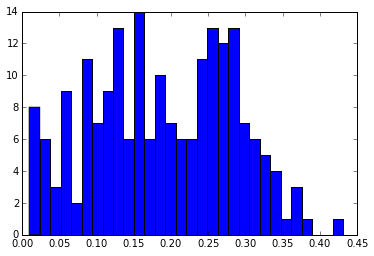

In [35]:
errors = np.mean(np.square(cdfs[:] - make_cdf(test_labels[:])), 1)
counts,scores,_ = plt.hist(errors, bins=30)

In [36]:
errors.mean()

0.18793450107488469

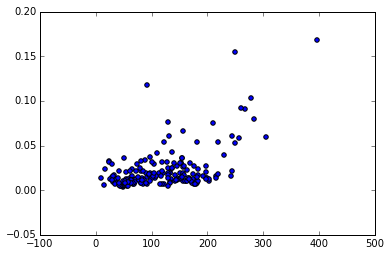

In [136]:
plt.scatter(test_labels, best_errs)

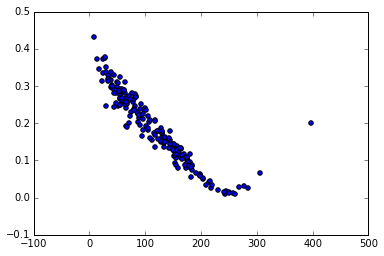

In [38]:
plt.scatter(test_labels, errors)

In [140]:
errors[test_labels > 320]

array([ 0.20074761])

In [141]:
best_errs[test_labels > 320]

array([ 0.16779826])

In [60]:
mask = (test_labels > 220)*(test_labels < 300)
errors[mask].mean()

0.017999962137713179

## ++++++++++++++++++++++ END SHIFTED MODEL ++++++++++++++++++++++++++++++

### Load the best model here

In [88]:
RUN_NAME = 'CRPS-MODEL-3.0'
DATA_DIR = 'netdata'
ITERS = 100000
START_ITER = 0
MODEL_LOAD_PATH = None
PIC_WIDTH = 32
### Architectural Hyperparameters
DEPTH_1 = 20         # The output depth of the first convolutional layer
DEPTH_2 = 40         # The output depth of the second convolutional layer
DEPTH_3 = 80         # The output depth of the second convolutional layer
DEPTH_4 = 150        # The output depth of the second convolutional layer
DEPTH_5 = 150        # The output depth of the second convolutional layer
DEPTH_6 = 150        # The output depth of the second convolutional layer
NUM_HIDDEN = 400     # Number of hidden units in the hidden layer
NUM_OUTPUTS = 600    # Number of output classes in the softmax layer
KERNEL_X = 3         # The width of the convolution kernel (using same for 1st and 2nd layers)
KERNEL_Y = 3         # The height of the convolution kernel (using same for 1st and 2nd layers)
mu = 0.0001
LEARNING_RATE = 1e-4

REGULARIZE_BIAS = False


NUM_INPUTS = 3       # Number of input channels
NUM_REPS = 64
MBSIZE = 100

TRAIN_LABEL_NOISE_STD = 2.
TRAIN_LABEL_SMOOTHING_STD = 0.
DATA_AUGMENTATION = False

DATA_MEDIAN_FILTER = False
DATA_UNIT_VAR = False
VAL_PER = 1000
DROPOUT = 0.5
ALSO_MIN_RMSE = False
TEMP_DIR_PATH = '.'
TRAIN_ALL = False
FILTER_BY_LABEL = False
#########################################
NUM_INPUTS = 9       # Number of input channels
NUM_REPS = 144
TRAIN_LABEL_NOISE_STD = 1.
TRAIN_LABEL_SMOOTHING_STD = 2.
DATA_AUGMENTATION = True
RUN_NAME = 'AUG-EXP'

In [89]:
MODEL_LOAD_PATH = 'AUG-EXP/model-9800'
best_cdfs = []

In [90]:
graph = tf.Graph()
with graph.as_default():
    ####################################### INPUT/OUTPUT PLACEHOLDERS ##############################################
    x = tf.placeholder(tf.float32, shape=[None, PIC_WIDTH, PIC_WIDTH, NUM_INPUTS]) #Placeholder for the input images
    y_ = tf.placeholder(tf.float32, shape=[None, NUM_OUTPUTS]) #Placeholder for the label cdfs
    weights = tf.placeholder(tf.float32, shape=[None, 1])

    ####################################### FIRST CONVOLUTIONAL LAYER ##############################################
    # The weight tensor has dimensions [kernel_size_x, kernel_size_y, num_input_channels, num_output_channels]
    W_conv1 = weight_variable([KERNEL_X, KERNEL_Y, NUM_INPUTS, DEPTH_1])
    b_conv1 = bias_variable([DEPTH_1])
    #Take the input image, reshape it to a 4D tensor with dimensions: [_, image_width, image_height, num_channels]
    #x_image = tf.reshape(x, [-1,32,32,3])
    # Convolve with kernel -> add bias -> apply ReLU -> max pool 
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    ####################################### SECOND CONVOLUTIONAL LAYER ##############################################
    W_conv2 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_1, DEPTH_2])
    b_conv2 = bias_variable([DEPTH_2])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    ####################################### THIRD CONVOLUTIONAL LAYER ##############################################
    W_conv3 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_2, DEPTH_3])
    b_conv3 = bias_variable([DEPTH_3])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)

    ####################################### FOURTH CONVOLUTIONAL LAYER ##############################################
    W_conv4 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_3, DEPTH_4])
    #W_conv4 = weight_variable([2, 2, DEPTH_3, DEPTH_4]) #Modified this to support 5x5
    b_conv4 = bias_variable([DEPTH_4])

    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
    # ####################################### FIFTH CONVOLUTIONAL LAYER ##############################################
    #This layer uses a 1x1 convolution
    W_conv5 = weight_variable([1, 1, DEPTH_4, DEPTH_5])
    b_conv5 = bias_variable([DEPTH_5])

    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = tf.nn.avg_pool(h_conv5,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_pool5_flat = tf.reshape(h_pool5, [-1, DEPTH_6])

    ############################################### DROPOUT ##########################################################
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_pool5_flat, keep_prob)

    ############################################# SOFTMAX OUTPUT LAYER ###############################################
    W_fc2 = weight_variable([DEPTH_5, NUM_OUTPUTS])
    b_fc2 = bias_variable([NUM_OUTPUTS])

    y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

    #Cumulative sum
    y = cumsum(y_conv)
    ##################################### SETTING UP THE OPTIMISATION PROBLEM #####################################
    crps = tf.reduce_mean(tf.reduce_mean(tf.square(y - y_), 1)*weights) #y_ here should be the label cdfs
    ### Could add learning rate decay here - 1e-4 is the current learning rate
    loss = crps + mu*(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)
                    + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                    + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_fc2))
#     if REGULARIZE_BIAS:
#         loss += mu*(tf.nn.l2_loss(b_conv1) + tf.nn.l2_loss(b_conv2)
#                 + tf.nn.l2_loss(b_conv3) + tf.nn.l2_loss(b_conv4)
#                 + tf.nn.l2_loss(b_conv5) + tf.nn.l2_loss(b_fc2))

    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    mean_y = tf.reduce_mean(tf.reshape(y,(-1, NUM_REPS, NUM_OUTPUTS)), 1)
    mean_crps = tf.reduce_mean(tf.reduce_mean(tf.square(mean_y - y_), 1)*weights)

    mean_crps_summ = tf.scalar_summary("mean crps", mean_crps)
    crps_summ = tf.scalar_summary("crps", crps)

In [93]:
X, y = batch(test[:,100:200], [])
best_cdfs = list(best_cdfs)
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    best_cdfs.extend(mean_y.eval(feed_dict={x:X, keep_prob: 1}))

best_cdfs = np.array(best_cdfs)
best_cdfs.shape

In [95]:
best_errs = np.mean(np.square(best_cdfs[:] - make_cdf(test_labels[:])), 1)

In [96]:
best_errs.mean()

0.02154622361472101

In [95]:
best_errs[test_labels>220].mean(), errors[test_labels>220].mean()

(0.076802474477180485, 0.035694463829734069)

In [127]:
pests = np.argmax(best_cdfs > 0.5, axis=1)
pests.shape

(200,)

In [114]:
np.sum(test_labels>220)

13

In [128]:
np.sum(pests>200)

15

In [134]:
best_errs[pests>200].mean()

0.046472730939947179

In [133]:
errors[pests>200].mean()

0.049008343528135011

### Mildly Shifted Model here

In [696]:
pests[pests>160].shape

(55,)

In [742]:
MODEL_LOAD_PATH = 'SHIFT-AUG-EXP3/model-47000'
mild_cdfs = []

In [743]:
mask = (pests>190)*(pests<230)
X, y = batch(test[:,mask], [])
mild_cdfs = list(mild_cdfs)
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    mild_cdfs.extend(mean_y.eval(feed_dict={x:X, keep_prob: 1}))

mild_cdfs = np.array(mild_cdfs)
mean_mild_cdfs = np.mean(mild_cdfs, axis=1)
mean_mild_cdfs.shape

(23, 600)

In [744]:
pests[mask]

array([191, 191, 191, 191, 191, 191, 191, 207, 191, 191, 207, 191, 191,
       207, 207, 191, 207, 207, 191, 207, 191, 207, 207])

In [745]:
mild_errs = np.mean(np.square(mean_mild_cdfs[:] - make_cdf(test_labels[mask])), 1)

In [746]:
mild_errs.mean()

0.032268045338288774

In [747]:
errors[mask].mean()

0.034461155160765228

In [695]:
pests = np.argmax(old_cdfs > 0.5, axis=1)
pests.shape

(200,)

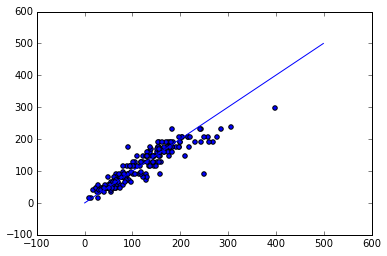

In [609]:
plt.scatter(test_labels, pests)
plt.plot(range(500), np.linspace(0,500, 500))

In [571]:
pests[:10]

array([176, 117, 117,  33, 176,  73, 169,  57, 176,  82])

In [562]:
ub = 1.
#ub = 0.989743
ers = []
for lb in np.linspace(0., 0.5, 50):
    mod_cdfs = (old_cdfs>lb)*old_cdfs*(old_cdfs<ub)+ np.ones(600)*(old_cdfs>ub)
    mod_errors = np.mean(np.square(mod_cdfs[:] - make_cdf(test_labels[:])), 1)
    ers.append(mod_errors.mean())

In [561]:
errors.mean(), mod_errors.mean()

(0.02154622361472101, 0.021546570467563031)

In [559]:
np.linspace(0.6, 1., 40)[38]

0.98974358974358978

In [563]:
np.argmin(ers)

0

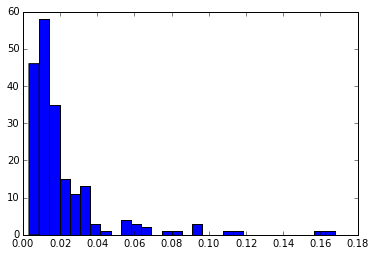

In [553]:
mod_errors = np.mean(np.square(mod_cdfs[:] - make_cdf(test_labels[:])), 1)
counts,scores,_ = plt.hist(mod_errors, bins=30)

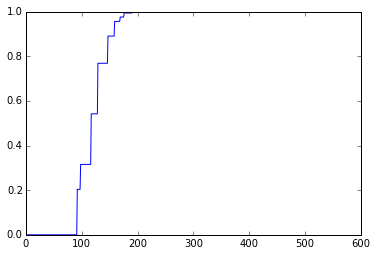

In [498]:
plt.plot((old_cdfs[1]>0.2)*old_cdfs[1])

In [ ]:
mod_cdfs = []
for cdf

In [497]:
np.argmax(old_cdfs[1] > 0.9)

159

In [482]:
old_cdfs = np.mean(cdfs, axis=1)
old_cdfs.shape

(200, 600)

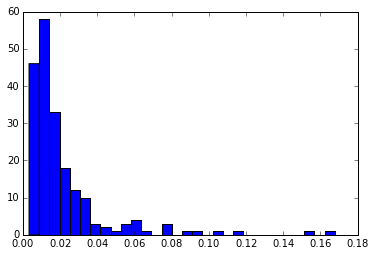

In [483]:
errors = np.mean(np.square(old_cdfs[:] - make_cdf(test_labels[:])), 1)
counts,scores,_ = plt.hist(errors, bins=30)

In [484]:
errors.mean(), errors[::2].mean(), errors[1::2].mean()

(0.02154622361472101, 0.025684414213131963, 0.017408033016310057)

In [490]:
errors.min(), errors.max()

(0.0033721650937688558, 0.16779826348925755)

In [491]:
scores[1:]

array([ 0.00885304,  0.0143339 ,  0.01981477,  0.02529564,  0.03077651,
        0.03625738,  0.04173825,  0.04721912,  0.05269999,  0.05818086,
        0.06366173,  0.0691426 ,  0.07462347,  0.08010434,  0.08558521,
        0.09106608,  0.09654695,  0.10202782,  0.10750869,  0.11298956,
        0.11847043,  0.1239513 ,  0.12943217,  0.13491304,  0.14039391,
        0.14587478,  0.15135565,  0.15683652,  0.16231739,  0.16779826])

In [486]:
np.cumsum(counts)/200.

array([ 0.23 ,  0.52 ,  0.685,  0.775,  0.835,  0.885,  0.9  ,  0.91 ,
        0.915,  0.93 ,  0.95 ,  0.955,  0.955,  0.97 ,  0.97 ,  0.975,
        0.98 ,  0.98 ,  0.985,  0.985,  0.99 ,  0.99 ,  0.99 ,  0.99 ,
        0.99 ,  0.99 ,  0.99 ,  0.995,  0.995,  1.   ])

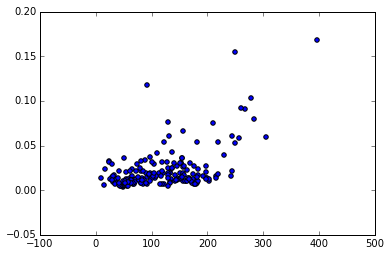

In [487]:
plt.scatter(test_labels, errors)

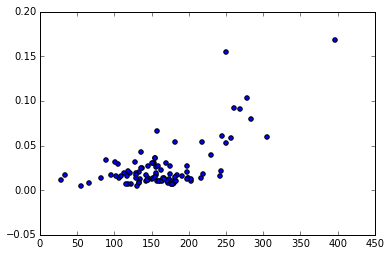

In [488]:
plt.scatter(test_labels[::2], errors[::2])

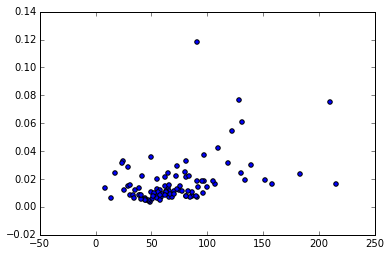

In [489]:
plt.scatter(test_labels[1::2], errors[1::2])

### Bad cases: 32, 46, 68, 76, +116, 118, 126, 148, 154, 168, +174, 186, 194, 69, 81, 123, 155, 169, +195

In [388]:
#bad = [32,46,68,76,116,126,148,154,168,174,186,194,69,81,123,155,169,195]
#good = [82,21,37,29,43,51,75,79,85,95,111,131,137,165,181]
bad = np.where(errors > 0.05)[0]
good = np.where(errors < 0.007)[0]
for case in good:
    fig = plt.figure(figsize=(10,6))
    for i in range(144):
        plt.plot(cdfs[case][i])
    
    plt.plot(np.mean(cdfs[case],axis=0), 'b', linewidth=4)
    plt.plot(make_cdf(test_labels[case:case+1])[0], 'r')
    plt.savefig('good_pred_'+str(case))
    plt.close(fig)

In [ ]:
np.argmax()

In [432]:
point_ests = []

for i in range(200):
    point_ests.append(np.argmax((old_cdfs[i])>0.8))

point_ests = np.array(point_ests)

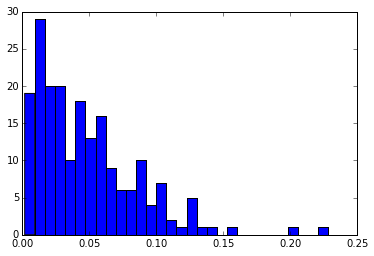

In [433]:
point_errors = np.mean(np.square(make_cdf(point_ests[:]) - make_cdf(test_labels[:])), 1)
counts,scores,_ = plt.hist(point_errors, bins=30)

In [434]:
point_ests[174]

167

In [437]:
uncertainty[174]

189

In [429]:
point_errors.mean()

0.032874999999999995

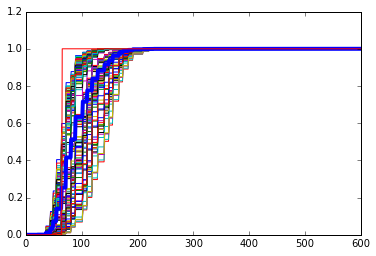

In [362]:
for i in range(144):
        plt.plot(cdfs[29][i])

plt.plot(np.mean(cdfs[29],axis=0), 'b', linewidth=4)
plt.plot(make_cdf(test_labels[29:29+1])[0], 'r')

In [396]:
uncertainty = []
for i in range(200):
    curve_centers = [np.argmax((cdfs[i][j])>0.6) for j in range(144)]
    left_bound = np.min(curve_centers)
    right_bound = np.max(curve_centers)
    uncertainty.append(right_bound - left_bound)

(array([  9.,  29.,  44.,  34.,  22.,  24.,   9.,   9.,   7.,   5.,   3.,
          1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([   0.  ,    9.45,   18.9 ,   28.35,   37.8 ,   47.25,   56.7 ,
          66.15,   75.6 ,   85.05,   94.5 ,  103.95,  113.4 ,  122.85,
         132.3 ,  141.75,  151.2 ,  160.65,  170.1 ,  179.55,  189.  ]),
 <a list of 20 Patch objects>)

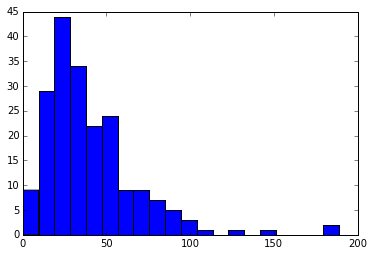

In [398]:
plt.hist(uncertainty, bins=20)

In [402]:
bad

array([ 32,  46,  68,  69,  76,  81, 116, 118, 123, 126, 148, 154, 155,
       168, 169, 174, 186, 194, 195])

In [467]:
errors[np.where(np.array(uncertainty) < 70)].mean()

0.022727304882956954

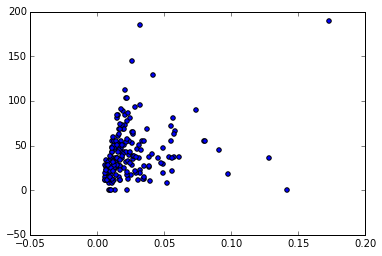

In [406]:
plt.scatter(errors, uncertainty)

### Trying out the max/min curve for diastole/systole

In [221]:
np.argmax([np.argmax((cdfs[174][i])>0.5) for i in range(144)])

45

In [275]:
bests = []
for i in range(200):  #cdfs.shape[0]):
    if i%2 == 0:
        bests.append(np.argmax([np.argmax((cdfs[i][j])>0.1) for j in range(144)]))
    else:
        bests.append(np.argmin([np.argmax((cdfs[i][j])>0.9) for j in range(144)]))

bests = np.array(bests)

In [276]:
bests

array([  0, 138,  36,  16,  96,  81,   7,  48,   0,   9, 109,   0,   0,
        45,   0,  72,  74,  18,   2, 135, 108,  36,   1,  63, 128,  81,
         0,  45,   0,  36,  72,  16,  72,  18,   0,   0, 108,  63,   1,
        15, 114,  36, 109,  33,   0,  39,   6,   0,   0,   0,   2,  45,
        18,  36,  72,  36,  18,  99,   1,  18,  74,   9,   0,   0, 108,
        36,  38, 140,  72,  45,  36,   1,  42,  18,   0, 117,  24, 138,
         0,  36,   0, 108,   7,   0,   1,  54,   0, 138,   0,  30, 108,
        48,   6, 108,   0,  36, 110, 138,  22, 108,  36,   0,  18,   9,
        36,  12,   1, 138,   8,  81,   0,  63,   2,   1,   0, 123,  55,
        10,  72,  99,   2,  63,   0,  88, 108,   0,   0,  66,   0, 108,
         0,   0,  37,  54,  72,  66, 109,  63,  72,   0,  36, 138,   0,
        54,  78,  36,  36, 126,   2, 126,   0,  36,  24,   0,  72,  18,
        72,  39, 108,   3,   2, 126,  36,  66,  90,  51,   1,  63, 109,
         0,  72,   0,  72, 117,  46,  79,  91, 132,  20, 117,  4

In [271]:
new_cdfs = []
for i in range(200):
    new_cdfs.append(cdfs[i, bests[i], :])
    
new_cdfs = np.array(new_cdfs)

In [277]:
new_cdfs.shape

(200, 600)

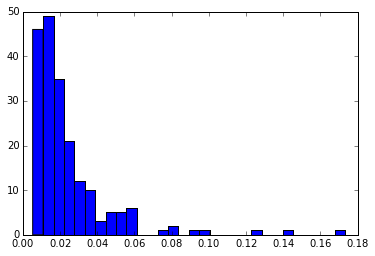

In [375]:
errors = np.mean(np.square(old_cdfs[:] - make_cdf(test_labels[:])), 1)
counts,scores,_ = plt.hist(errors, bins=30)

In [383]:
np.where(errors > 0.05)

(array([ 32,  46,  68,  69,  76,  81, 116, 118, 123, 126, 148, 154, 155,
        168, 169, 174, 186, 194, 195]),)

In [378]:
errors.mean(), errors[::2].mean(), errors[1::2].mean()

(0.024039212247872362, 0.027462733991073227, 0.020615690504671502)

0.0274627339911


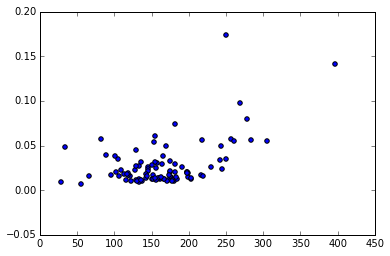

In [379]:
print errors[::2].mean()
plt.scatter(test_labels[::2], errors[::2])

In [246]:
old_cdfs = np.mean(cdfs, axis=1)
old_cdfs.shape

(200, 600)

In [253]:
np.mean(np.square(old_cdfs - make_cdf(test_labels[:])), 1).mean()

0.024039212247872362

### Trying out the curve of minimal uncertainty

In [ ]:
errors = np.mean(np.square(cdfs[:] - make_cdf(test_labels[:])), 1)
counts,scores,_ = plt.hist(errors, bins=30)

### ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [108]:
np.where(test_labels > 200)

(array([ 10,  68,  72,  92,  98, 116, 117, 118, 126, 134, 148, 152, 154,
        155, 168, 174, 178, 186, 196, 198]),)

In [139]:
np.where(errors < 0.006)[0].shape

(5,)

### Change batch to just get 3

In [167]:
test[1:2,:,:,:,:,:].shape

(1, 200, 2, 8, 32, 32)

In [ ]:
def batch(dat, labels):
    '''Takes dat as a (num_groups, num_cases, slices_per_group, num_times,
    rsize, csize) tensor and returns (num_cases * num_combs, rsize, csize,
    num_groups) where num_combs is slices_per_group**num_groups and each
    case is represented by '''

    num_slice_groups, num_cases, slices_per_group, num_times, rsize, csize = np.shape(dat)
    # there are 8 combinations of slices, and 8 time steps
    num_time_groups = 3
    num_groups = num_time_groups*num_slice_groups

    num_slice_combs = (slices_per_group**num_slice_groups)
    num_time_combs = 18
    num_combs = num_time_combs*num_slice_combs

    data = np.zeros((num_cases*num_combs,rsize,csize,num_groups), dtype='float16')
    labels = np.repeat(labels, num_combs)

    slice_perms = [(i,j,k) for i in range(slices_per_group)
                    for j in range(slices_per_group)
                    for k in range(slices_per_group)]
    time_perms = [(i,j,k) for i in range(num_times//3)
                    for j in range(num_times//3,2*num_times//3)
                    for k in range(2*num_times//3,num_times)]
    comb = 0
    for (i,j,k) in slice_perms:
        for (x,y,z) in time_perms:
            data[comb::num_combs,:,:,0] = dat[0][:, i, x]
            data[comb::num_combs,:,:,1] = dat[1][:, j, x]
            data[comb::num_combs,:,:,2] = dat[2][:, k, x]
            #
            data[comb::num_combs,:,:,3] = dat[0][:, i, y]
            data[comb::num_combs,:,:,4] = dat[1][:, j, y]
            data[comb::num_combs,:,:,5] = dat[2][:, k, y]
            #
            data[comb::num_combs,:,:,6] = dat[0][:, i, z]
            data[comb::num_combs,:,:,7] = dat[1][:, j, z]
            data[comb::num_combs,:,:,8] = dat[2][:, k, z]
            comb += 1

    return data, labels.reshape((-1,1))

In [119]:
test.shape

(3, 200, 2, 8, 32, 32)

In [147]:
def get_params_from_npz(path):
    x = np.load(path)
    return zip(*sorted(x.items(), key=lambda x: int(x[0].split('_')[1])))[1]

In [148]:
weights = get_params_from_npz('params1.npz')

<Container object of 3 artists>

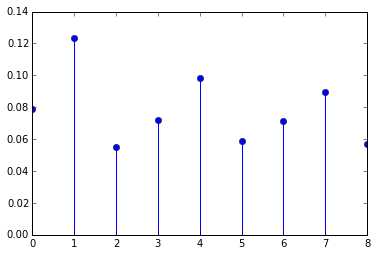

In [163]:
plt.stem([np.abs(weights[0][:,:,i,:]).mean() for i in range(9)])

In [120]:
case = 10
ims = dash(test[:,case,0,:,:,:])
ims.shape

(96, 256)

In [142]:
for case in np.where(errors < 0.006)[0]:
    fig = plt.figure(figsize=(15,6))
    if case % 2 == 0:
        ims = dash(test[:,case,0,:,:,:])
        plt.imshow(ims)
        plt.savefig('dia_'+str(case))
        plt.close(fig)
    else:
        ims = dash(test[:,case,1,:,:,:])
        plt.imshow(ims)
        plt.savefig('sys_'+str(case))
        plt.close(fig)

In [58]:
all_labels = np.concatenate((test_labels, train_labels))
all_labels.shape

(1000,)

### Make sure it's the right CRPS for the model

In [105]:
np.mean(np.square(cdfs[:] - make_cdf(test_labels[:])))

0.024039212247872362

## Analyse the errors

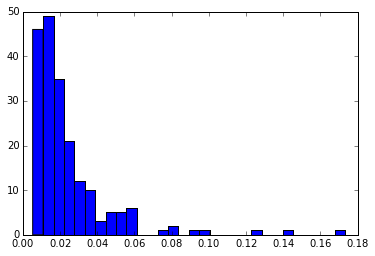

In [113]:
errors = np.mean(np.square(cdfs[:] - make_cdf(test_labels[:])), 1)
counts,scores,_ = plt.hist(errors, bins=30)

In [16]:
scores

array([ 0.00614706,  0.01186751,  0.01758795,  0.0233084 ,  0.02902884,
        0.03474929,  0.04046974,  0.04619018,  0.05191063,  0.05763107,
        0.06335152,  0.06907196,  0.07479241,  0.08051285,  0.0862333 ,
        0.09195374,  0.09767419,  0.10339463,  0.10911508,  0.11483553,
        0.12055597,  0.12627642,  0.13199686,  0.13771731,  0.14343775,
        0.1491582 ,  0.15487864,  0.16059909,  0.16631953,  0.17203998,
        0.17776042])

In [17]:
np.cumsum(counts)/200.

array([ 0.26 ,  0.515,  0.675,  0.755,  0.835,  0.895,  0.905,  0.925,
        0.935,  0.945,  0.955,  0.965,  0.965,  0.97 ,  0.975,  0.975,
        0.98 ,  0.995,  0.995,  0.995,  0.995,  0.995,  0.995,  0.995,
        0.995,  0.995,  0.995,  0.995,  0.995,  1.   ])

In [27]:
np.mean(sorted(errors)[:200])

0.023818338644408348

In [44]:
lb = 250
ub = 600

In [45]:
test_labels[(test_labels>lb)*(test_labels<ub)];

In [46]:
big_pred = cdfs[(test_labels>lb)*(test_labels<ub)]
big_test = test_labels[(test_labels>lb)*(test_labels<ub)]
np.mean(np.square(big_pred - make_cdf(big_test)))

0.072349958938078607

In [524]:
test_labels[60:90]

array([ 157. ,   55. ,  121.1,   39.2,  152.2,   55.1,  173.7,   67. ,
        218.4,  128.9,  154.7,   49.8,  230.5,  183.5,  156. ,   55. ,
        154. ,   73. ,  142. ,   39.6,   33. ,   17. ,   55.5,   14. ,
        117.9,   48.1,  105.9,   23.6,  160.4,   80.8])

In [527]:
np.where(test_labels == 157.)

(array([18, 60]),)

In [536]:
cdfs[test_labels >= 250].shape

(8, 600)

In [47]:
widths = []
for ex in range(200):
    widths.append(cdfs[ex][(cdfs[ex] > 0.1)*(cdfs[ex] < 0.9)].shape[0])

widths = np.array(widths)

In [48]:
widths.mean()

66.420000000000002

In [49]:
test_labels[test_labels>250].shape

(7,)

In [50]:
test_labels.mean()

118.66149999999999

In [52]:
test_labels[widths>100]

array([ 173.7,  154.7,  100.1,  128. ,   28.6,  118.2,  215. ,  133.5,
        102. ,  249.7,  109.4])

In [645]:
widths[test_labels>250].mean(), widths[test_labels>250].std()

(87.714285714285708, 17.886261972445187)

In [646]:
widths[test_labels<200].mean(), widths[test_labels<200].std()

(61.177777777777777, 24.521907564814036)

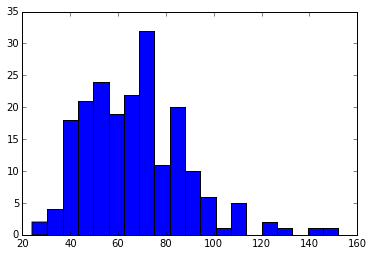

In [55]:

_,_,_ = plt.hist(widths, bins=20)

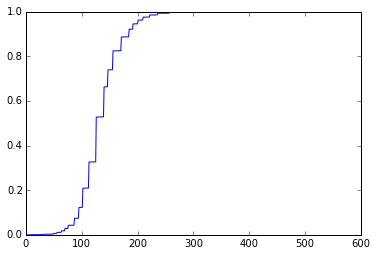

In [56]:
plt.plot(cdfs[18])

In [509]:
test_labels[test_labels>lb]

array([ 175.7,  175.6,  162. ,  180.8,  243.3,  151.6,  198.4,  157. ,
        174.4,  198. ,  174.8,  177.5,  153. ,  199. ,  178.9,  166.9,
        155.9,  172.7,  191.5,  152.3,  150.7,  157. ,  152.2,  173.7,
        218.4,  154.7,  230.5,  183.5,  156. ,  154. ,  160.4,  181.6,
        202.9,  175.4,  244.1,  164.1,  158.9,  184.1,  171.3,  155.5,
        397.1,  215. ,  284. ,  197.6,  169.5,  165. ,  305.5,  158.3,
        154.5,  241.7,  166.6,  183.3,  181.3,  277.6,  177.8,  203.6,
        268.3,  209.9,  198.1,  257. ,  249.7,  162.7,  250. ,  150.1,
        260.6,  182. ,  215.9,  219.3])

In [510]:
big_pred = cdfs[test_labels>lb]
big_test = test_labels[test_labels>lb]

In [511]:
np.mean(np.square(big_pred - make_cdf(big_test)))

0.032509422458924124

### Error distribution on diastole

0.0275892003118


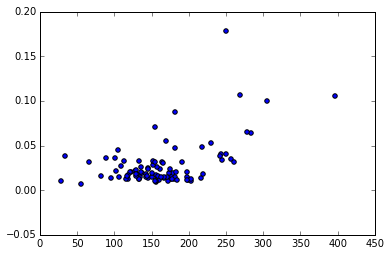

In [58]:
print errors[::2].mean()
plt.scatter(test_labels[::2], errors[::2])

### Error distribution on systole

0.0200474769771


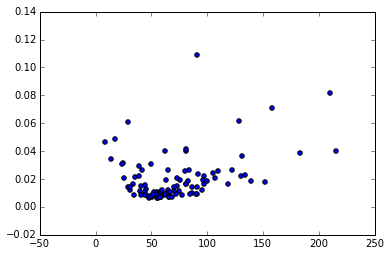

In [59]:
print errors[1::2].mean()
plt.scatter(test_labels[1::2], errors[1::2])

### Total Errors

In [74]:
errors[test_labels<150].mean()

0.019139550413124564

In [73]:
errors[test_labels>150].mean()

0.032900692269841575

In [61]:
train_labels[train_labels>150].shape, test_labels[test_labels>150].shape

((255,), (68,))

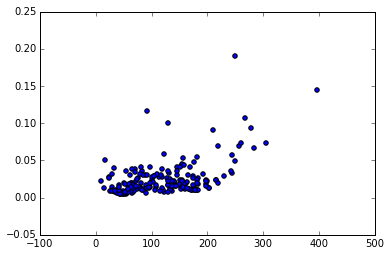

In [666]:
plt.scatter(test_labels, errors)

### Save the test output PDFs

In [237]:
y1_train = np.load('y1_train.npy')
y1_test = np.load('y1_test.npy')

In [238]:
new_y1_train = np.cumsum(y1_train, axis=1)
new_y1_test = np.cumsum(y1_test, axis=1)

In [242]:
np.save('new_y1_test', new_y1_test)
np.save('new_y1_train', new_y1_train)

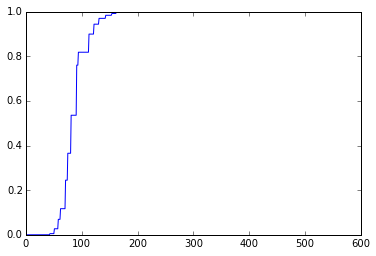

In [241]:
plt.plot(new_y1_test[199])

In [266]:
cdfs.shape

(800, 600)

In [267]:
np.save('y2_train', cdfs)

### Look at some of the output CDFs

In [ ]:
case = 0
plt.plot(cdfs[case])
plt.plot(make_cdf(test_labels[case:case+1])[0])